# Non-linear factor models in Finance

## Overview

The notebook contains the various non-linear neural network factor models. 

The notebook has the following struture: 

1. Support classes
2. The 9 factor base case for the neural network _base_ factor model and the neural network _extended_ factor model
3. The autoencoder
4. The "AE 20 factor" base case similar to the "9 factor" case for the _base_ factor model and the _extended_ factor model

The _base_ and _extended_ neural network models takes a dictornary containing the dataloader for the training data set, the validation data set and the test data set.

Each dataloader applies a certain data structure that is a specific for the design of the model.

Each neural network factor model has a specifc function call i.e. for training and statistics, where specific design parameters are input. A sample function call for each neural network type (described in the article) is provided, but design parameters can just be changed in these calls to run other configurations.

Function calls for the autoencoder is provided for the intrinsic dimension 20 i.e. 20 factor case for the linear AE (but the non-linear case can be activated changing a flag in the code). The part of the code that generates new $(\alpha , \beta)$'s by the adaptive model and store these in a file can be activated changing a flag. 

The notebook needs the module "invlib.py" provided in the folder to read data files and in case the adaptive model is called and data files needs to be downloader to the same folder from my google drive (link is provided in the README file in the github).


## Base classes for data

In [1]:
# Import of libraries

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import invlib


In [2]:
# Global variables 

factor_levels_fname="factor_levels_data003" # File name on factor levels matching factor weights

factor_weights_fname="factor_weights_data003" # File name of factor weights from adaptive model

prediction_error_fname="pred_error_data003" # File name of prediction errors from adaptive model

return_levels_fname="return_levels_data003" # File name for return levels 

ticker_sector_np_fname="ticker_sector_data003" # File name for numpy stucture with sector id

factor_order_fname="factor_order_data.txt" # File with of factor names in adaptive model

asset_order_fname="asset_order_data.txt" # File with asset names in adaptive model

sector_name_fname="sector_id.txt"  # File with sector names

no_beta_factors=9  # Number of beta factors

no_assets=638 # Number of assets

no_dataset=4134  # Number of data

batch_size = 1000  # Batch size

training_set_no_data=1378 # Number of data in training set

validation_set_no_data=1378 # Number of data in validation set

test_set_no_data=1378 # Number of data in test set



In [3]:
# Database applied to read datafiles and store results in numpy structure

class database():
    """
    Class that loads data
    """
    def __init__(self,factor_levels_fn,factor_weights_fn,prediction_error_fn,return_levels_fn,ticker_sector_np_fn):
        """ Loads data into numpy arrays
        """

        loader=invlib.asset_data()

        tmp_factor_weights=loader.load_return_data_from_file(factor_weights_fn)
        self.factor_weights_np=np.reshape(tmp_factor_weights,(no_dataset,no_beta_factors+1,no_assets))
        self.return_data_np=loader.load_return_data_from_file(return_levels_fn)
        self.error_affine_model_np=loader.load_return_data_from_file(prediction_error_fn)
        self.factor_level_np=loader.load_return_data_from_file(factor_levels_fname)
        self.sector_id_np=loader.load_return_data_from_file(ticker_sector_np_fn)

data=database(factor_levels_fname,factor_weights_fname,prediction_error_fname,return_levels_fname,ticker_sector_np_fname)


## Support classes for neural networks

In [4]:
# Convert a binary vector to digit (applied for sector codes)

def bin2int(bvec):

    sum=0
    vv=1

    for ii in range(len(bvec)):
        sum+=bvec[ii]*vv
        vv*=2

    return sum

In [5]:
# General function that trains the neural network in one epoch by iterating over all the batches

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        loss = loss_fn(pred.flatten(), y.flatten())

        # Compute return variance

        output_var=(y**2).sum()/torch.numel(y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()




In [6]:
# This function calculates loss and R² for a dataset given a model

def c_stat(dataloader, model, loss_fn,label_=None,pr_stat=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    t_loss,output_var, nn  = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            t_loss += loss_fn(pred.flatten(), y.flatten()).item()          
            output_var+=(y**2).sum()/torch.numel(y)
            nn+=1

    R2=1-t_loss/output_var
    
    if pr_stat:
        print(f"{label_} R^2={R2}\n")

    
    return R2, t_loss/nn


In [7]:
# This function runs the training of the neural network and calculate statistics


def run_model(model,optimizer,loss_fn,epochs,dataloader,fn=None,label=None):
    """
    Train model and test against validation and test data and print results
    
    model :  nn.module
        neural network
    optimizer : torch.optim
        applied for training of model
    loss_fn : torch.nn
        loss function
    epochs : int>0
        number of iterations in optimizer
    dataloader : dictionary 
        dictionary containing dataloaders for "train","validation","test"
    """

    # Initialisation
    
    train_iter=[]
    train_loss=[]
    train_R2=[]

    valid_iter=[]
    valid_loss=[]
    valid_R2=[]

    test_iter=[]
    test_loss=[]
    test_R2=[]

    max_train_R2=0
    max_valid_R2=0
    max_test_R2=0
    max_iter=-1
    
    

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(dataloader['train'], model, loss_fn, optimizer)

        R2_train,loss_train=c_stat(dataloader['train'], model, loss_fn,label_="training")
        R2_validation,loss_validation=c_stat(dataloader['validation'], model, loss_fn,label_="validation")
        R2_test,loss_test=c_stat(dataloader['test'], model, loss_fn,label_="test")

        #    if R2_train>=0 and R2_validation>=0 and R2_test>=0:
        if True: 
        
            train_iter.append(t)
            train_loss.append(loss_train)
            train_R2.append(R2_train.numpy(force=True))
    
            valid_iter.append(t)
            valid_loss.append(loss_validation)
            valid_R2.append(R2_validation.numpy(force=True))

            test_iter.append(t)
            test_loss.append(loss_test)
            test_R2.append(R2_test.numpy(force=True))

        # Search for pareto optimal solution

        if R2_train.numpy(force=True)>=max_train_R2 and R2_validation.numpy(force=True)>=max_valid_R2 and R2_test.numpy(force=True)>=max_test_R2:
            max_train_R2=R2_train.numpy(force=True)
            max_valid_R2=R2_validation.numpy(force=True)
            max_test_R2=R2_test.numpy(force=True)
            max_iter=t

    # Print results

    print(f'Pareto optimal solution: iter*: {max_iter:.0f} training_R2*: {max_train_R2:.6f} validation_R2*: {max_valid_R2:.6f} test_R2*: {max_test_R2:.6f}')

    # Plot results

    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
#    fig = plt.figure(figsize=(6,8)) # temp
#    plt.subplot(2,1,1) # temporary
    plt.plot(train_iter, train_loss, label='train_loss')
    plt.plot(valid_iter, valid_loss, label='valid_loss')
    plt.plot(test_iter, test_loss, label='test_loss')
    plt.legend()

    plt.subplot(1, 2, 2)
#    plt.subplot(2, 1, 2) # temp
    plt.plot(train_iter, train_R2, label='train_R2')
    plt.plot(valid_iter, valid_R2, label='valid_R2')
    plt.plot(test_iter, test_R2, label='test_R2')
    plt.legend()

    
    # Save results to files
    
    if fn!=None: 
        fig.savefig(fn+'.png',format='png')
        

        f=open(fn+'.txt','w')

        if label!=None:
            f.write(label)

        f.write(f'\n Pareto optimal solution:\n iter*: {max_iter:.0f} training_R2*: {max_train_R2:.6f} validation_R2*: {max_valid_R2:.6f} test_R2*: {max_test_R2:.6f}\n')
        f.write(f'#iteration training_loss validation_loss test_loss training_R2 validation_R2 test_R2\n')
        for ii in range(len(train_iter)):
            f.write(f'{train_iter[ii]:.0f} {train_loss[ii]:.6f} {valid_loss[ii]:.6f} {test_loss[ii]:.6f} {train_R2[ii]:.6f} {valid_R2[ii]:.6f} {test_R2[ii]:.6f}\n')
        f.close()


    plt.show()    


In [8]:
# Calculate sector statisics

def c_sec_stat(model,loss_fn,mdata,sec_id_fn,from_id,to_id,fn=None,label=None):

    sec_id_lst=invlib.rd_ticker_file(sec_id_fn)
    no_sec=len(sec_id_lst)
    R2_lst=[]
    sec_mdata,sec_nitem=mdata.filter_data(sec_id_lst,from_id,to_id)
    tot_nitem=np.array(sec_nitem).sum()
    sum_loss2=0
    sum_var=0

    for sec_id in range(no_sec):
        dloader=DataLoader(sec_mdata[sec_id],batch_size=batch_size,shuffle=True)
        
        size = len(dloader.dataset)
        num_batches = len(dloader)
        model.eval()
        t_loss, output_var  = 0, 0
        with torch.no_grad():
            for X, y in dloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                t_loss += loss_fn(pred.flatten(), y).item()
                output_var+=(y**2).sum()/torch.numel(y)

        sum_loss2+=t_loss
        sum_var+=output_var

        R2=1.0-t_loss/output_var
        R2_lst.append(float(R2.float()))

    R2=1.0-sum_loss2/sum_var
    R2_lst.append(float(R2.float()))

    label_lst=[]
    for ii in range(no_sec):
        str_=sec_id_lst[ii]+f' ({(sec_nitem[ii]/tot_nitem*100):.1f}%)'
        label_lst.append(str_)
        
    str_=f'Total (100.0%)'
    label_lst.append(str_)        

    # plot diagramme

    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(8, 4))
        sns.barplot(x=label_lst, y=R2_lst)
        plt.xticks(rotation=90)
        plt.title("R2 for "+label)
        plt.ylabel("R2")

        if fn!=None: 
            plt.savefig(fn+'_R2'+label+'.png',format='png',bbox_inches='tight')
        
        plt.show()

    # Save data to file

    if fn!=None: 
        f=open(fn+'.txt','a')
        f.write('\nR2 on sectors '+label+'\n')
        for ii in range(len(sec_id_lst)):
            f.write(f'{sec_id_lst[ii]} {R2_lst[ii]:.2f}\n')
        f.close()

    # return data

    return sec_id_lst,R2_lst
    
        

### Neural network block functions

In [9]:
def gen_FFN_block(feature_vec_dim,output_vec_dim,no_hidden_layers,no_nodes_in_layer,P_dropout,activation=None):
    """ Generates a FFN in a list """
    
    if activation==None:

        activation=nn.ReLU()
            
    else:
            
        activation=activation
            
    FFN=[]
        
    FFN.append(nn.Linear(feature_vec_dim, no_nodes_in_layer))
    FFN.append(nn.Dropout(p=P_dropout))
    FFN.append(nn.BatchNorm1d(no_nodes_in_layer))
    FFN.append(activation)        
        
    for ii in range(no_hidden_layers):
        FFN.append(nn.Linear(no_nodes_in_layer, no_nodes_in_layer))
        FFN.append(nn.Dropout(p=P_dropout))
        FFN.append(nn.BatchNorm1d(no_nodes_in_layer))    
        FFN.append(activation)

            
    FFN.append(nn.Linear(no_nodes_in_layer, output_vec_dim))
        
    return FFN


def gen_AE_block(no_nodes_in_layer_lst,P_dropout,activation=None):
    """ Generate Autoencoder """

    if activation==None:

        activation=nn.ReLU()
            
    else:
            
        activation=activation
            
    AE=[]

    no_layers=len(no_nodes_in_layer_lst)
        
    for ii in range(no_layers-2):
        AE.append(nn.Linear(no_nodes_in_layer_lst[ii], no_nodes_in_layer_lst[ii+1]))
        AE.append(nn.Dropout(p=P_dropout))
        AE.append(nn.BatchNorm1d(no_nodes_in_layer_lst[ii+1]))   
        if activation!=None: 
            AE.append(activation)

            
    AE.append(nn.Linear(no_nodes_in_layer_lst[no_layers-2],no_nodes_in_layer_lst[no_layers-1]))
        
    return AE


def gen_Conv1D_block(channel_in,no_conv_layers,channel_out_lst,kernel_size_lst,seq_lgth): 
    """ Generate a convolutional block """
            
    CNN=[]


    C_in=channel_in
    C_L_in=seq_lgth


    for ii in range(no_conv_layers):

        CNN.append(nn.Conv1d(in_channels=C_in,out_channels=channel_out_lst[ii],\
                                 kernel_size=kernel_size_lst[ii]))

        CNN.append(nn.MaxPool1d(kernel_size=kernel_size_lst[ii]))


            
        C_out=channel_out_lst[ii]
        stride_M=kernel_size_lst[ii]

        C_L_out=C_L_in-(kernel_size_lst[ii]-1)-1+1
        M_L_in=C_L_out
        M_L_out=int((M_L_in-(kernel_size_lst[ii]-1)-1)/stride_M+1)

        C_L_in=M_L_out
        C_in=C_out


    return CNN,C_out,M_L_out
        
        

# Sector statistics for input data (adaptive affine model)

Adaptive affine model training R^2=42.14%
Adaptive affine model validation R^2=25.93%
Adaptive affine model test R^2=38.06%


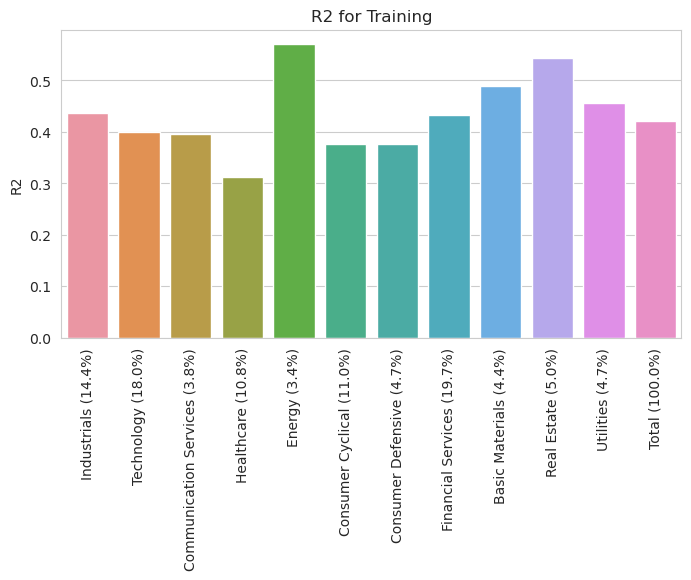

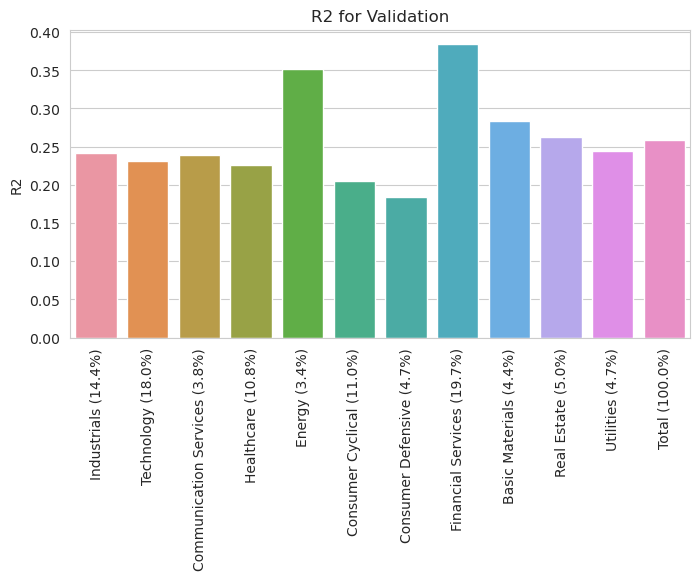

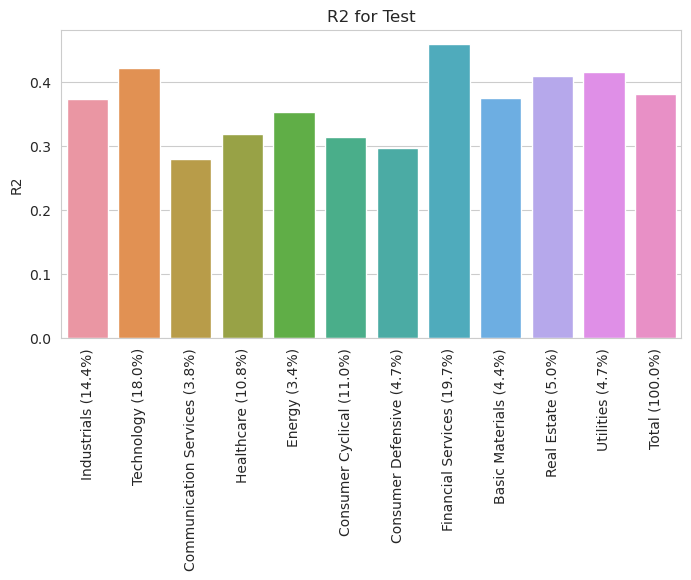

(['Industrials',
  'Technology',
  'Communication Services',
  'Healthcare',
  'Energy',
  'Consumer Cyclical',
  'Consumer Defensive',
  'Financial Services',
  'Basic Materials',
  'Real Estate',
  'Utilities'],
 [0.3737848439134409,
  0.4221719295253926,
  0.27942102994450224,
  0.3176304322258363,
  0.35241403801154225,
  0.31357172224187313,
  0.2963384665520763,
  0.45882536494277915,
  0.37533088320161334,
  0.4085330763571795,
  0.4145811268878117,
  0.38056381014432983])

In [10]:
# Calculate R^2 for adaptive affine model

def c_stat_adaptive_model(data,sec_id_fn,from_id,to_id,fn=None,label=None):

        # Initialise

        sec_id_lst=invlib.rd_ticker_file(sec_id_fn)
        sec_id_vec=data.sector_id_np
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=(to_id-from_id+1)*no_assets
        feature_dim_t=(2*no_beta_factors+1)   
            
        # Create lists of data
        
        i_data_lst=[]
        e_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(np.array([0]))
            e_data_lst.append(np.array([0]))

        # Create index lists

        i_index_lst=[]
        o_index_lst=[]

        for ii in range(no_sec):
            i_index_lst.append([])
            o_index_lst.append([])
        
        # Assign data to sector lists

        for jj in range(no_assets):
            si=int(bin2int(sec_id_vec[jj])) # Sector id binary
            i_index_lst[si].append((no_beta_factors+jj)) 
            o_index_lst[si].append(jj)

        tot_var=0
        tot_error2=0

        # Calculate R2 for sectors

        sec_nitem=[]
        R2_lst=[]
        tot_nitem=0


        for ii in range(no_sec):
            error2=(data.error_affine_model_np[from_id:to_id,o_index_lst[ii]]**2).sum()
            var_=(data.return_data_np[from_id:to_id,i_index_lst[ii]]**2).sum()
            tot_var+=var_
            tot_error2+=error2
            R2_lst.append((1-error2/var_))
            nitem=len(i_index_lst[ii])
            sec_nitem.append(nitem)
            tot_nitem+=nitem

        R2_lst.append((1-tot_error2/tot_var))

        # Create label list 
            
        label_lst=[]
        for ii in range(no_sec):
            str_=sec_id_lst[ii]+f' ({(sec_nitem[ii]/tot_nitem*100):.1f}%)'
            label_lst.append(str_)
        
        str_=f'Total (100.0%)'
        label_lst.append(str_)        

        # plot diagramme

        with sns.axes_style('whitegrid'):
            plt.figure(figsize=(8, 4))
            sns.barplot(x=label_lst, y=R2_lst)
            plt.xticks(rotation=90)
            plt.title("R2 for "+label)
            plt.ylabel("R2")

            if fn!=None: 
                plt.savefig(fn+'_R2'+label+'.png',format='png',bbox_inches='tight')
        
            plt.show()

        # Save data to file

        if fn!=None: 
            f=open(fn+'.txt','a')
            f.write('\nR2 on sectors '+label+'\n')
            for ii in range(len(sec_id_lst)):
                f.write(f'{sec_id_lst[ii]} {R2_lst[ii]:.2f}\n')
            f.close()

        # return data

        return sec_id_lst,R2_lst




i1=training_set_no_data
i2=i1+validation_set_no_data
i3=i2+test_set_no_data

R2_amodel_training=1-(data.error_affine_model_np[:i1]**2).sum()/(data.return_data_np[:i1,no_beta_factors:]**2).sum()
R2_amodel_validation=1-(data.error_affine_model_np[i1:i2]**2).sum()/(data.return_data_np[i1:i2,no_beta_factors:]**2).sum()
R2_amodel_test=1-(data.error_affine_model_np[i2:]**2).sum()/(data.return_data_np[i2:,no_beta_factors:]**2).sum()

print(f'Adaptive affine model training R^2={(R2_amodel_training*100):.2f}%')
print(f'Adaptive affine model validation R^2={(R2_amodel_validation*100):.2f}%')
print(f'Adaptive affine model test R^2={(R2_amodel_test*100):.2f}%')

# Calculate on sector level

adaptive_data_fn='adaptive'

c_stat_adaptive_model(data,sector_name_fname,0,i1,fn=adaptive_data_fn+'_training',label='Training')
c_stat_adaptive_model(data,sector_name_fname,i1,i2,fn=adaptive_data_fn+'_validation',label='Validation')
c_stat_adaptive_model(data,sector_name_fname,i2,i3,fn=adaptive_data_fn+'_test',label='Test')

# _Base_ neural network factor model

This section contains the code for the _base_ model. The related database applied in the dataloader is denoted market_data_base2 (for model B2). 

##  _Base_ model: $(\alpha ,(\beta \times \Delta F))$ as input

In [11]:
#Database for basic neural network model B2


class data_base(Dataset):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,input_data=None,output_data=None):
        """ 
        Loads data and store en numpy array
        """

        self.input_data_t=input_data
        self.output_data_t=output_data

                

    def __len__(self):
        """ Returns number of data """
        return len(self.output_data_t)


    def __getitem__(self,idx):
        """ Return data sample with id idx """

        return self.input_data_t[idx],self.output_data_t[idx]

class market_data_base2(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        no_data=(to_id-from_id+1)*no_assets

        dim_feature_vec=(no_beta_factors+1)  # (alhpa,beta)-vector and factor change
        
        t_vec=np.zeros(no_beta_factors,dtype=np.float32)

        self.input_data_np=np.zeros((no_data,dim_feature_vec),dtype=np.float32)

        self.output_data_np=np.zeros(no_data,dtype=np.float32)

        p_input_data=0

        for ii in range(from_id,to_id+1):
            for jj in range(no_assets):
                t_vec=data.factor_weights_np[ii,1:,jj]*data.return_data_np[ii,:no_beta_factors]
                vv=np.array([data.factor_weights_np[ii,0,jj]])
                self.input_data_np[p_input_data,:]=np.concatenate((vv,t_vec))
                self.output_data_np[p_input_data]=data.return_data_np[ii,no_beta_factors+jj]
                p_input_data+=1

        self.data=data

        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np) 

        super().__init__(input_data_t,output_data_t)
        
    def filter_data(self,sec_id_lst,from_id,to_id):


        # Initialise
        
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=(to_id-from_id+1)
        dim_feature_vec=(2*no_beta_factors+1)
        sec_id_vec=np.zeros(no_assets,dtype=int)     
        is_initialised=np.zeros(no_sec,dtype=bool)

        # Map company id to sector id       

        for ii in range(no_assets):
            si=int(bin2int(data.sector_id_np[ii]))
            sec_id_vec[ii]=si
            
        # Create lists of data
        
        i_data_lst=[]
        o_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(np.array([0.0]))
            o_data_lst.append(np.array([0.0]))

        
        for jj in range(no_assets):
            si=sec_id_vec[jj]
            if is_initialised[si]:
                t_vec=self.data.factor_weights_np[from_id:to_id+1,1:,jj]*self.data.return_data_np[from_id:to_id+1,:no_beta_factors]              
                vv=self.data.factor_weights_np[from_id:to_id+1,0,jj].reshape(to_id-from_id+1,1)
                mm=np.concatenate((vv,t_vec),axis=1,dtype=np.float32)
                i_data_lst[si]=np.concatenate((i_data_lst[si],mm),axis=0)
                o_data_lst[si]=np.concatenate((o_data_lst[si],self.data.return_data_np[from_id:to_id+1,no_beta_factors+jj]),axis=0,dtype=np.float32)
            else:
                t_vec=self.data.factor_weights_np[from_id:to_id+1,1:,jj]*self.data.return_data_np[from_id:to_id+1,:no_beta_factors]                              
                vv=self.data.factor_weights_np[from_id:to_id+1,0,jj].reshape(to_id-from_id+1,1)
                i_data_lst[si]=np.concatenate((vv,t_vec),axis=1,dtype=np.float32)
                o_data_lst[si]=self.data.return_data_np[from_id:to_id+1,no_beta_factors+jj]
                is_initialised[si]=True 
                
        # Count number of data points

        for ii in range(no_sec):
            dim_sec_data[ii]=o_data_lst[ii].shape[0]                

        # Create data base list                
        
        datab_lst=[]
        
        for ii in range(no_sec):
            datab_lst.append(data_base(torch.from_numpy(i_data_lst[ii]),torch.from_numpy(o_data_lst[ii])))
            
        # return data base list and list with number of data points            

        return datab_lst,dim_sec_data
         


        





In [12]:
# Create data loaders.

training_data_b2=market_data_base2(data,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_b2=market_data_base2(data,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_b2=market_data_base2(data,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_b2 = DataLoader(training_data_b2, batch_size=batch_size,shuffle=True)
validation_dataloader_b2=DataLoader(validation_data_b2, batch_size=batch_size,shuffle=True)
test_dataloader_b2 = DataLoader(test_data_b2, batch_size=batch_size,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_b2.__len__()}')
print(f'number of validation batches {validation_dataloader_b2.__len__()}')
print(f'number of test batches {test_dataloader_b2.__len__()}')



number of training batches 880
number of validation batches 880
number of test batches 880


### _Base_ model

In [13]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
#    if torch.backends.mps.is_available()
#    else "cpu"
)
print(f"Using {device} device")


class NN_B(nn.Module):
    def __init__(self,feature_vec_dim,output_vec_dim,num_layers,num_hidden_nodes,P_dropout,activation=None):

        super().__init__()

        if activation==None:

            self.activation=nn.ReLU()
            
        else:
            
            self.activation=activation
            
        FFN=[]
        
        FFN.append(nn.Linear(feature_vec_dim, num_hidden_nodes))
        FFN.append(nn.Dropout(p=P_dropout))
        FFN.append(nn.BatchNorm1d(num_hidden_nodes))
        FFN.append(self.activation)        
        
        for ii in range(num_layers):
            FFN.append(nn.Linear(num_hidden_nodes, num_hidden_nodes))
            FFN.append(nn.Dropout(p=P_dropout))
            FFN.append(nn.BatchNorm1d(num_hidden_nodes))    
            FFN.append(self.activation)

            
        FFN.append(nn.Linear(num_hidden_nodes, output_vec_dim))
              
        
        self.FFN=nn.ModuleList(FFN)
            

    def forward(self, x):

        for ff in self.FFN:
            x=ff(x)
            
        return_vec=x 
                
        return return_vec



Using cuda device


### _Base_ model interface 

In [14]:
# Model B2

def run_b2(feature_vec_dim_b2,output_vec_dim,num_layers,num_hidden_nodes,P_dropout,lr,epochs,fname,model_info_b2,data_loader_b2,dataset):


    model_b2 = NN_B(feature_vec_dim=feature_vec_dim_b2,output_vec_dim=output_vec_dim,num_layers=num_layers,\
                num_hidden_nodes=num_hidden_nodes,P_dropout=P_dropout).to(device)
    print(model_b2)

    loss_fn_b2 = nn.MSELoss()
    optimizer_b2 = torch.optim.Adam(model_b2.parameters(), lr=lr)

    # Run base factor model

    run_model(model_b2,optimizer_b2,loss_fn_b2,epochs,dataloader_b2,fname,label=model_info_b2)

    # Calculate R2 on sectors

    from_id,to_id=0,training_set_no_data-1
    c_sec_stat(model_b2,loss_fn_b2,dataset['train'],sector_name_fname,from_id,to_id,fname,'training_data')

    from_id,to_id=training_set_no_data,training_set_no_data+validation_set_no_data-1
    c_sec_stat(model_b2,loss_fn_b2,dataset['validation'],sector_name_fname,from_id,to_id,fname,'validation_data')

    from_id,to_id=training_set_no_data+validation_set_no_data,training_set_no_data+validation_set_no_data+test_set_no_data-1
    c_sec_stat(model_b2,loss_fn_b2,dataset['test'],sector_name_fname,from_id,to_id,fname,'test_data')

### Run  _base_ model (number of factors is 9)

NN_B(
  (activation): ReLU()
  (FFN): ModuleList(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=50, out_features=50, bias=True)
    (17): Dropout(p=0.2, inplace=False)
    (18): BatchNorm1d(50, e

training R^2=0.3811417818069458

validation R^2=0.19151806831359863

test R^2=0.34617429971694946

Epoch 51
-------------------------------
training R^2=0.3745397925376892

validation R^2=0.18132013082504272

test R^2=0.34339165687561035

Epoch 52
-------------------------------
training R^2=0.39015716314315796

validation R^2=0.1914467215538025

test R^2=0.35632914304733276

Epoch 53
-------------------------------
training R^2=0.361935019493103

validation R^2=0.1444244384765625

test R^2=0.3153647780418396

Epoch 54
-------------------------------
training R^2=0.3914684057235718

validation R^2=0.20114868879318237

test R^2=0.35181522369384766

Epoch 55
-------------------------------
training R^2=0.39051181077957153

validation R^2=0.21252977848052979

test R^2=0.35863828659057617

Epoch 56
-------------------------------
training R^2=0.3923720717430115

validation R^2=0.2336820363998413

test R^2=0.364620566368103

Epoch 57
-------------------------------
training R^2=0.3896278738

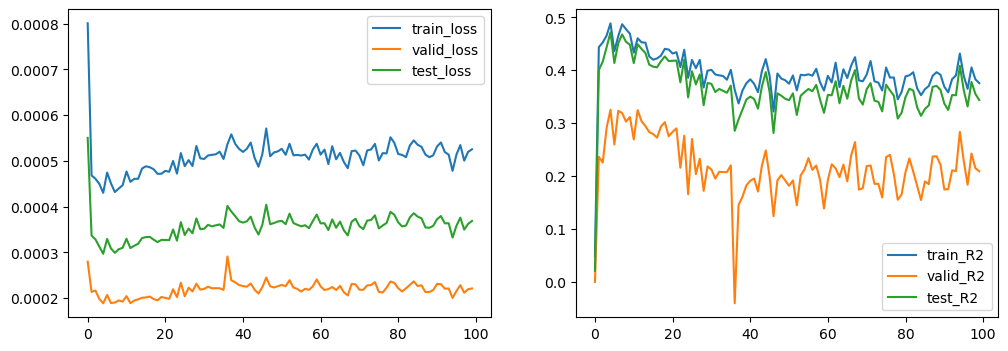

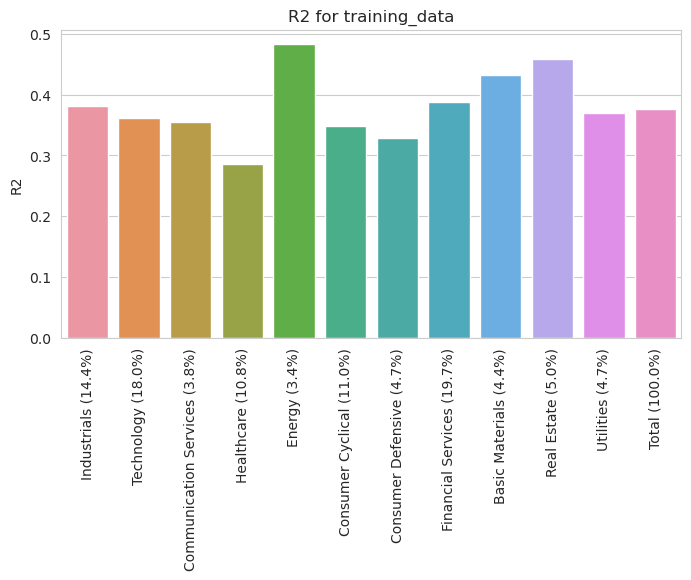

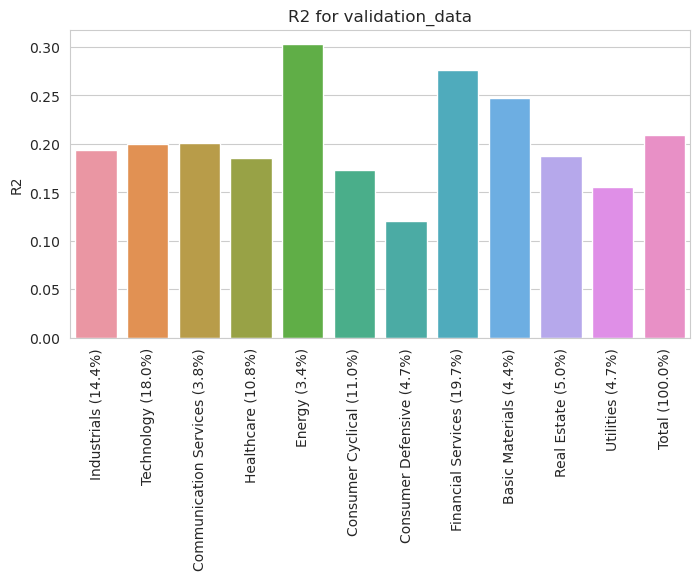

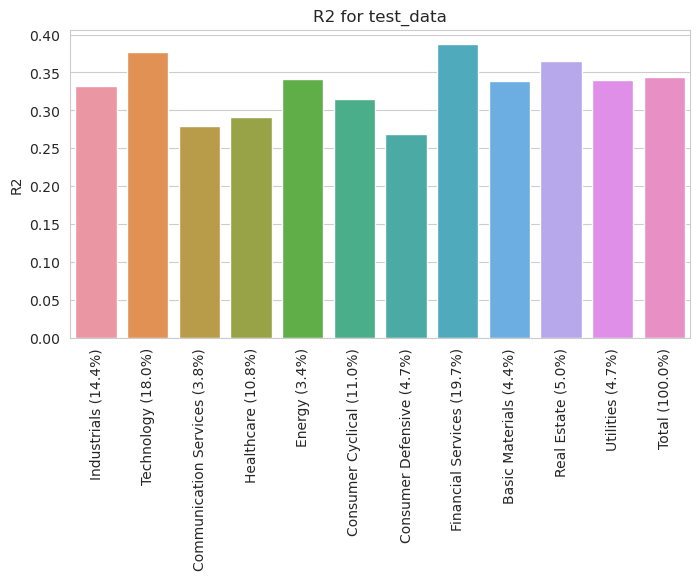

In [15]:
# ------- Run base model

dataset={
        'train' : training_data_b2,
        'validation' : validation_data_b2,
        'test' : test_data_b2 
    }

dataloader_b2={
        'train' : train_dataloader_b2,
        'validation' : validation_dataloader_b2,
        'test' : test_dataloader_b2 
    }

model_info="Model: base model"


feature_vec_dim_b2=no_beta_factors+1
output_vec_dim=1
num_layers=5
num_hidden_nodes=50
P_dropout=0.2
lr=1e-3
epochs=100
fname='run_base'

run_b2(feature_vec_dim_b2,output_vec_dim,num_layers,num_hidden_nodes,P_dropout,lr,epochs,fname,model_info,dataloader_b2,dataset)

# _Extended_ neural network factor model

## Datasets

In the following code the different data sets for the _extended_ model are generated.

### Dataset: market_data_adv (input $(F,\Delta F,\alpha,\beta ,\mbox{sector id},R)$)

In [16]:
class market_data_adv(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,T_backward=1,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """
        
        self.T_backward=T_backward


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        if from_id<T_backward:
            no_data=(to_id-T_backward+2)*no_assets
            start_id=T_backward-1
        else:        
            no_data=(to_id-from_id+1)*no_assets
            start_id=from_id

        self.dim_feature_vec_t=max(2*no_beta_factors+5,3*no_beta_factors+2) # (alhpa,beta)-vector and factor change and sector id

        self.dim_feature_vec_0=2*no_beta_factors+1
        
        self.input_data_np=np.zeros((no_data,T_backward,self.dim_feature_vec_t),dtype=np.float32)

        self.output_data_np=np.zeros(no_data,dtype=np.float32)

        p_input_data=0

        self.data=data

        for ii in range(start_id,to_id+1):
            for jj in range(no_assets):
                for tt in range(T_backward):
                    if tt==0: 
                        self.input_data_np[p_input_data,T_backward-1-tt,:2*no_beta_factors+5]=\
                                                    np.concatenate((data.factor_weights_np[ii,:,jj],\
                                                    data.return_data_np[ii,:no_beta_factors],data.sector_id_np[jj,:]))
                    else:        
                        self.input_data_np[p_input_data,T_backward-1-tt,:3*no_beta_factors+2]=\
                                                    np.concatenate((data.factor_weights_np[ii-tt,:,jj],\
                                                    data.return_data_np[ii-tt,:no_beta_factors],\
                                                    np.array([data.return_data_np[ii-tt,no_beta_factors+jj]]),\
                                                    data.factor_level_np[ii-tt,:]))   
                    
                self.output_data_np[p_input_data]=data.return_data_np[ii,no_beta_factors+jj]
                p_input_data+=1



        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np)     

        super().__init__(input_data_t,output_data_t)


    def filter_data(self,sec_id_lst,from_id,to_id):


        # Initialise
        
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=self.input_data_t.shape[0]
        feature_dim_t=(2*no_beta_factors+1)   


            
        # Create lists of data
        
        i_data_lst=[]
        o_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(torch.zeros(1))
            o_data_lst.append(torch.zeros(1))

        # Create index lists

        index_lst=[]

        for ii in range(no_sec):
            index_lst.append([])
        
        # Assign data to sector lists

        for ii in range(n_data_item):
            si=int(bin2int(self.input_data_t[ii,self.T_backward-1,self.dim_feature_vec_0:(self.dim_feature_vec_0+4)])) # Sector id binary
            index_lst[si].append(ii)

        # Assign data to i_data_lst and o_data_lst

        for si in range(no_sec):
            i_data_lst[si]=self.input_data_t[index_lst[si]]
            o_data_lst[si]=self.output_data_t[index_lst[si]]                                  
    
                
        # Count number of data points

        for ii in range(no_sec):
            dim_sec_data[ii]=o_data_lst[ii].shape[0]                

        # Create data base list                
        
        datab_lst=[]
        
        for ii in range(no_sec):
            datab_lst.append(data_base(i_data_lst[ii],o_data_lst[ii]))
            
        # return data base list and list with number of data points            

        return datab_lst,dim_sec_data         


# Parameters

T_bkwd=10 # Number of trading days there is look back >=2

batch_size_adv=1000 # Batch size

# Create data loaders.

training_data_adv=market_data_adv(data,T_bkwd,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_adv=market_data_adv(data,T_bkwd,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_adv=market_data_adv(data,T_bkwd,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_adv = DataLoader(training_data_adv, batch_size=batch_size_adv,shuffle=True)
validation_dataloader_adv=DataLoader(validation_data_adv, batch_size=batch_size_adv,shuffle=True)
test_dataloader_adv = DataLoader(test_data_adv, batch_size=batch_size_adv,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_adv.__len__()}')
print(f'number of validation batches {validation_dataloader_adv.__len__()}')
print(f'number of test batches {test_dataloader_adv.__len__()}')



number of training batches 874
number of validation batches 880
number of test batches 880


### Data set E2: model input $( \Delta F_{proj}, F,R)$

In [17]:
class market_data_E2(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,T_backward=1,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """
        
        self.T_backward=T_backward


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        if from_id<T_backward:
            no_data=(to_id-T_backward+2)*no_assets
            start_id=T_backward-1
        else:        
            no_data=(to_id-from_id+1)*no_assets
            start_id=from_id

        self.dim_feature_vec_t=max(no_beta_factors+5,2*no_beta_factors+2) # (alhpa,beta)-vector and factor change and sector id

        self.dim_feature_vec_0=no_beta_factors+1
        
        self.input_data_np=np.zeros((no_data,T_backward,self.dim_feature_vec_t),dtype=np.float32)

        self.output_data_np=np.zeros(no_data,dtype=np.float32)

        p_input_data=0

        self.data=data

        for ii in range(start_id,to_id+1):
            for jj in range(no_assets):
                for tt in range(T_backward):
                    if tt==0: 
                        t_vec=data.factor_weights_np[ii,1:,jj]*data.return_data_np[ii,:no_beta_factors]
                        vv=np.array([data.factor_weights_np[ii,0,jj]])
                        self.input_data_np[p_input_data,T_backward-1-tt,:no_beta_factors+5]=\
                                                    np.concatenate((vv,t_vec,data.sector_id_np[jj,:]))
                    else:  
                        t_vec=data.factor_weights_np[ii-tt,1:,jj]*data.return_data_np[ii-tt,:no_beta_factors]
                        vv=np.array([data.factor_weights_np[ii-tt,0,jj]])
                        self.input_data_np[p_input_data,T_backward-1-tt,:2*no_beta_factors+2]=\
                                                    np.concatenate((vv,t_vec,\
                                                    np.array([data.return_data_np[ii-tt,no_beta_factors+jj]]),\
                                                    data.factor_level_np[ii-tt,:]))   
                    
                self.output_data_np[p_input_data]=data.return_data_np[ii,no_beta_factors+jj]
                p_input_data+=1



        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np)     

        super().__init__(input_data_t,output_data_t)


    def filter_data(self,sec_id_lst,from_id,to_id):


        # Initialise
        
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=self.input_data_t.shape[0]
        feature_dim_t=(2*no_beta_factors+1)   


            
        # Create lists of data
        
        i_data_lst=[]
        o_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(torch.zeros(1))
            o_data_lst.append(torch.zeros(1))

        # Create index lists

        index_lst=[]

        for ii in range(no_sec):
            index_lst.append([])
        
        # Assign data to sector lists

        for ii in range(n_data_item):
            si=int(bin2int(self.input_data_t[ii,self.T_backward-1,self.dim_feature_vec_0:(self.dim_feature_vec_0+4)])) # Sector id binary
            index_lst[si].append(ii)

        # Assign data to i_data_lst and o_data_lst

        for si in range(no_sec):
            i_data_lst[si]=self.input_data_t[index_lst[si]]
            o_data_lst[si]=self.output_data_t[index_lst[si]]                                  
    
                
        # Count number of data points

        for ii in range(no_sec):
            dim_sec_data[ii]=o_data_lst[ii].shape[0]                

        # Create data base list                
        
        datab_lst=[]
        
        for ii in range(no_sec):
            datab_lst.append(data_base(i_data_lst[ii],o_data_lst[ii]))
            
        # return data base list and list with number of data points            

        return datab_lst,dim_sec_data         


# Parameters

T_bkwd=10 # Number of trading days there is look back >=2

batch_size_E2=1000 # Batch size

# Create data loaders.

training_data_E2=market_data_E2(data,T_bkwd,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_E2=market_data_E2(data,T_bkwd,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_E2=market_data_E2(data,T_bkwd,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_E2 = DataLoader(training_data_E2, batch_size=batch_size_E2,shuffle=True)
validation_dataloader_E2=DataLoader(validation_data_E2, batch_size=batch_size_E2,shuffle=True)
test_dataloader_E2 = DataLoader(test_data_E2, batch_size=batch_size_E2,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_E2.__len__()}')
print(f'number of validation batches {validation_dataloader_E2.__len__()}')
print(f'number of test batches {test_dataloader_E2.__len__()}')




number of training batches 874
number of validation batches 880
number of test batches 880


### Data set E3: model input $( \Delta F_{proj}, R)$

In [18]:
class market_data_E3(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,T_backward=1,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """
        
        self.T_backward=T_backward


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        if from_id<T_backward:
            no_data=(to_id-T_backward+2)*no_assets
            start_id=T_backward-1
        else:        
            no_data=(to_id-from_id+1)*no_assets
            start_id=from_id

        self.dim_feature_vec_t=max(no_beta_factors+5,no_beta_factors+2) # (alhpa,beta)-vector and factor change and sector id

        self.dim_feature_vec_0=no_beta_factors+1
        
        self.input_data_np=np.zeros((no_data,T_backward,self.dim_feature_vec_t),dtype=np.float32)

        self.output_data_np=np.zeros(no_data,dtype=np.float32)

        p_input_data=0

        self.data=data

        for ii in range(start_id,to_id+1):
            for jj in range(no_assets):
                for tt in range(T_backward):
                    if tt==0: 
                        t_vec=data.factor_weights_np[ii,1:,jj]*data.return_data_np[ii,:no_beta_factors]
                        vv=np.array([data.factor_weights_np[ii,0,jj]])
                        self.input_data_np[p_input_data,T_backward-1-tt,:no_beta_factors+5]=\
                                                    np.concatenate((vv,t_vec,data.sector_id_np[jj,:]))
                    else:  
                        t_vec=data.factor_weights_np[ii-tt,1:,jj]*data.return_data_np[ii-tt,:no_beta_factors]
                        vv=np.array([data.factor_weights_np[ii-tt,0,jj]])
                        self.input_data_np[p_input_data,T_backward-1-tt,:no_beta_factors+2]=\
                                                    np.concatenate((vv,t_vec,\
                                                    np.array([data.return_data_np[ii-tt,no_beta_factors+jj]])))
  
                    
                self.output_data_np[p_input_data]=data.return_data_np[ii,no_beta_factors+jj]
                p_input_data+=1



        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np)     

        super().__init__(input_data_t,output_data_t)


    def filter_data(self,sec_id_lst,from_id,to_id):


        # Initialise
        
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=self.input_data_t.shape[0]
        feature_dim_t=(2*no_beta_factors+1)   


            
        # Create lists of data
        
        i_data_lst=[]
        o_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(torch.zeros(1))
            o_data_lst.append(torch.zeros(1))

        # Create index lists

        index_lst=[]

        for ii in range(no_sec):
            index_lst.append([])
        
        # Assign data to sector lists

        for ii in range(n_data_item):
            si=int(bin2int(self.input_data_t[ii,self.T_backward-1,self.dim_feature_vec_0:(self.dim_feature_vec_0+4)])) # Sector id binary
            index_lst[si].append(ii)

        # Assign data to i_data_lst and o_data_lst

        for si in range(no_sec):
            i_data_lst[si]=self.input_data_t[index_lst[si]]
            o_data_lst[si]=self.output_data_t[index_lst[si]]                                  
    
                
        # Count number of data points

        for ii in range(no_sec):
            dim_sec_data[ii]=o_data_lst[ii].shape[0]                

        # Create data base list                
        
        datab_lst=[]
        
        for ii in range(no_sec):
            datab_lst.append(data_base(i_data_lst[ii],o_data_lst[ii]))
            
        # return data base list and list with number of data points            

        return datab_lst,dim_sec_data         


# Parameters

T_bkwd=10 # Number of trading days there is look back >=2

batch_size_E3=1000 # Batch size

# Create data loaders.

training_data_E3=market_data_E3(data,T_bkwd,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_E3=market_data_E3(data,T_bkwd,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_E3=market_data_E3(data,T_bkwd,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_E3 = DataLoader(training_data_E3, batch_size=batch_size_E3,shuffle=True)
validation_dataloader_E3=DataLoader(validation_data_E3, batch_size=batch_size_E3,shuffle=True)
test_dataloader_E3 = DataLoader(test_data_E3, batch_size=batch_size_E3,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_E3.__len__()}')
print(f'number of validation batches {validation_dataloader_E3.__len__()}')
print(f'number of test batches {test_dataloader_E3.__len__()}')


number of training batches 874
number of validation batches 880
number of test batches 880


## Model E2

In [19]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
#    if torch.backends.mps.is_available()
#    else "cpu"
)
print(f"Using {device} device")

# Define EM2 model


class NN_EM2(nn.Module):
    def __init__(self,feature_vec_cr_dim,feature_vec_LSTM_dim,feature_vec_FF_dim,output_vec_dim,\
                 no_conv_layers,channel_out,kernel_size,seq_lgth,\
                 cr_aggr_no_layers,cr_aggr_no_nodes,cr_output_vec_dim,\
                 LSTM_hidden_layer_dim,\
                 LSTM_no_layers,LSTM_no_nodes,LSTM_output_vec_dim,
                 num_layers_FF,num_hidden_nodes_FF,P_dropout,activation=None,batch_first=True):

        super().__init__()

        # Set data

        self.feature_vec_cr_dim=feature_vec_cr_dim
        self.feature_vec_LSTM_dim=feature_vec_LSTM_dim
        self.feature_vec_FF_dim=feature_vec_FF_dim
        self.output_vec_dim=output_vec_dim
        self.seq_lgth=seq_lgth

        if activation==None:

            self.activation=nn.ReLU()
            
        else:
            
            self.activation=activation
            
        # ---- Convolution block    
            
        if no_conv_layers>0: 
            
            self.flag_conv_block=True 

            # Convolution layer

            channel_out_lst=[]
            kernel_size_lst=[]
            for ii in range(no_conv_layers):
                channel_out_lst.append(channel_out)
                kernel_size_lst.append(kernel_size)

            conv_lst,C_out,L_out=gen_Conv1D_block(feature_vec_cr_dim,no_conv_layers,channel_out_lst,\
                                               kernel_size_lst,seq_lgth)
            
            self.conv_block=nn.Sequential(*conv_lst)   
            
            # Aggregation layer FFN 
            
            CR_aggr_layer_input_dim=C_out*L_out
            
            CR_aggr_layer=gen_FFN_block(feature_vec_dim=CR_aggr_layer_input_dim,output_vec_dim=cr_output_vec_dim,\
                                        no_hidden_layers=cr_aggr_no_layers,\
                               no_nodes_in_layer=cr_aggr_no_nodes,P_dropout=P_dropout,activation=activation) 
            
            self.conv_aggr_block=nn.Sequential(*CR_aggr_layer)

            dim_cr_out=cr_output_vec_dim
                
 
            
        else:
            
            self.flag_conv_block=False

            dim_cr_out=0
                 
                

        # ------------------- LSTM block
        
        
        
        if LSTM_hidden_layer_dim>0: 
            
            self.flag_LSTM_block=True
            
            
            # LSTM layer
            


            self.LSTM_block=nn.LSTM(input_size=feature_vec_LSTM_dim,hidden_size=LSTM_hidden_layer_dim,\
                       batch_first=batch_first) # LSTM x_t=(alpha,beta,d_factor,return)
            

        
            # Aggregation layer FFN
            
            LSTM_aggr_input_dim=LSTM_hidden_layer_dim*seq_lgth
        
            LSTM_aggr_layer=gen_FFN_block(feature_vec_dim=LSTM_aggr_input_dim,output_vec_dim=LSTM_output_vec_dim,\
                                          no_hidden_layers=LSTM_no_layers,\
                               no_nodes_in_layer=LSTM_no_nodes,P_dropout=P_dropout,activation=activation) 
            

            
            self.LSTM_aggr_block=nn.Sequential(*LSTM_aggr_layer)

            dim_LSTM_out=LSTM_output_vec_dim
        

                

                
        else:
            
            self.flag_LSTM_block=False

            dim_LSTM_out=0
            
        # ------------  Model aggregation block FFN    


        # FFN layer

        dim_FFN_input=dim_cr_out+dim_LSTM_out+feature_vec_FF_dim-4
            
        FFN=gen_FFN_block(feature_vec_dim=dim_FFN_input,output_vec_dim=output_vec_dim,\
                          no_hidden_layers=num_layers_FF,\
                          no_nodes_in_layer=num_hidden_nodes_FF,P_dropout=P_dropout,activation=activation) 
              
        
        self.FFN_block=nn.Sequential(*FFN)
            
    

    def forward(self, x):

        feature_dim_t=self.feature_vec_FF_dim-4
        
        x_LSTM=x[:,:self.seq_lgth,:self.feature_vec_LSTM_dim]
        x_cr=x[:,:self.seq_lgth,self.feature_vec_LSTM_dim:]
        x_model_t=x[:,self.seq_lgth,:feature_dim_t]
        x_sector=x[:,self.seq_lgth,feature_dim_t:(feature_dim_t+4)]
        
              
        
        # -------- Convolution block
        
        if self.flag_conv_block: 
            
            x_cr=torch.permute(x_cr,(0,2,1))
         
            x_cr=self.conv_block(x_cr)
        
            x_cr=torch.flatten(x_cr,start_dim=1)

            x_cr=self.conv_aggr_block(x_cr)
        
        
        
        # --------- LSTM block 
        
        if self.flag_LSTM_block: 
        
            x_LSTM,param=self.LSTM_block(x_LSTM)                
                
            x_LSTM=torch.flatten(x_LSTM,start_dim=1)

            x_LSTM=self.LSTM_aggr_block(x_LSTM)


        # catenation of variables for FFN model

        if self.flag_conv_block and self.flag_LSTM_block: 
            x_model=torch.cat((x_LSTM,x_cr,x_model_t),dim=1)
        elif self.flag_conv_block:
            x_model=torch.cat((x_cr,x_model_t),dim=1)
        elif self.flag_LSTM_block:
            x_model=torch.cat((x_LSTM,x_model_t),dim=1)
        else:
            x_model=x_model_t
        

        
        return_vec=self.FFN_block(x_model)
        
        # Return result
                
        return return_vec
        



Using cuda device


### Interface to model E2

In [20]:
def run_E2_E2(T_bkwd,\
          feature_vec_cr_dim,\
          feature_vec_LSTM_dim,\
          feature_vec_FF_dim,\
          no_conv_layers,\
          channel_out,\
          kernel_size,\
          cr_aggr_no_layers,\
          cr_aggr_no_nodes,\
          cr_output_vec_dim,\
          LSTM_hidden_layer_dim,\
          LSTM_no_layers,\
          LSTM_no_nodes,\
          LSTM_output_vec_dim,\
          num_layers_FF,\
          num_hidden_nodes_FF,\
          P_dropout,\
          epochs_E2,\
          fname,\
          dataloader,\
          dataset,\
          model_info="",\
          lr=5e-4,\
          weight_decay=1e-9):

    # -----  Model specification E3

    
    seq_lgth=T_bkwd-1



    model_E2_E2 = NN_EM2(feature_vec_cr_dim,feature_vec_LSTM_dim,feature_vec_FF_dim,output_vec_dim,\
                  no_conv_layers,channel_out,kernel_size,seq_lgth,\
                  cr_aggr_no_layers,cr_aggr_no_nodes,cr_output_vec_dim,\
                  LSTM_hidden_layer_dim,\
                  LSTM_no_layers,LSTM_no_nodes,LSTM_output_vec_dim,
                  num_layers_FF,num_hidden_nodes_FF,P_dropout).to(device)
    print(model_E2_E2)

    loss_fn_E2_E2 = nn.MSELoss()
    optimizer_E2_E2 = torch.optim.Adam(model_E2_E2.parameters(), lr=lr,weight_decay=weight_decay)

    # Run EM2 factor model 
    
    dataloader_E2=dataloader

    run_model(model_E2_E2,optimizer_E2_E2,loss_fn_E2_E2,epochs_E2,dataloader_E2,fname,label=model_info)

    # Calculate R2 on sectors

    from_id,to_id=0,training_set_no_data-1
    c_sec_stat(model_E2_E2,loss_fn_E2_E2,dataset['train'],sector_name_fname,from_id,to_id,fname,'training_data')

    from_id,to_id=training_set_no_data,training_set_no_data+validation_set_no_data-1
    c_sec_stat(model_E2_E2,loss_fn_E2_E2,dataset['validation'],sector_name_fname,from_id,to_id,fname,'validation_data')

    from_id,to_id=training_set_no_data+validation_set_no_data,training_set_no_data+validation_set_no_data+test_set_no_data-1
    c_sec_stat(model_E2_E2,loss_fn_E2_E2,dataset['test'],sector_name_fname,from_id,to_id,fname,'test_data')

### Run the _extended_ model (number of factors is 9)

NN_EM2(
  (activation): ReLU()
  (conv_block): Sequential(
    (0): Conv1d(9, 81, kernel_size=(2,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(81, 81, kernel_size=(2,), stride=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_aggr_block): Sequential(
    (0): Linear(in_features=81, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (

test R^2=0.343971312046051

Epoch 28
-------------------------------
training R^2=0.47589540481567383

validation R^2=0.2570115327835083

test R^2=0.3506694436073303

Epoch 29
-------------------------------
training R^2=0.4755236506462097

validation R^2=0.2544682025909424

test R^2=0.3585153818130493

Epoch 30
-------------------------------
training R^2=0.4810667634010315

validation R^2=0.26153481006622314

test R^2=0.3619217276573181

Epoch 31
-------------------------------
training R^2=0.49282366037368774

validation R^2=0.2709870934486389

test R^2=0.3707525134086609

Epoch 32
-------------------------------
training R^2=0.4914173483848572

validation R^2=0.2635892629623413

test R^2=0.3636630177497864

Epoch 33
-------------------------------
training R^2=0.5015007257461548

validation R^2=0.2709481716156006

test R^2=0.372494101524353

Epoch 34
-------------------------------
training R^2=0.5071142911911011

validation R^2=0.26689308881759644

test R^2=0.3623202443122864

Epo

training R^2=0.6594197154045105

validation R^2=0.3494911789894104

test R^2=0.3890302777290344

Epoch 88
-------------------------------
training R^2=0.6830910444259644

validation R^2=0.33576422929763794

test R^2=0.3367692232131958

Epoch 89
-------------------------------
training R^2=0.6808937788009644

validation R^2=0.27172982692718506

test R^2=0.3629435896873474

Epoch 90
-------------------------------
training R^2=0.6819307804107666

validation R^2=0.3218427300453186

test R^2=0.3790404796600342

Epoch 91
-------------------------------
training R^2=0.6850875616073608

validation R^2=0.32999950647354126

test R^2=0.3384245038032532

Epoch 92
-------------------------------
training R^2=0.6983855962753296

validation R^2=0.32516443729400635

test R^2=0.3644212484359741

Epoch 93
-------------------------------
training R^2=0.6876899003982544

validation R^2=0.31230032444000244

test R^2=0.35368120670318604

Epoch 94
-------------------------------
training R^2=0.6878548860549

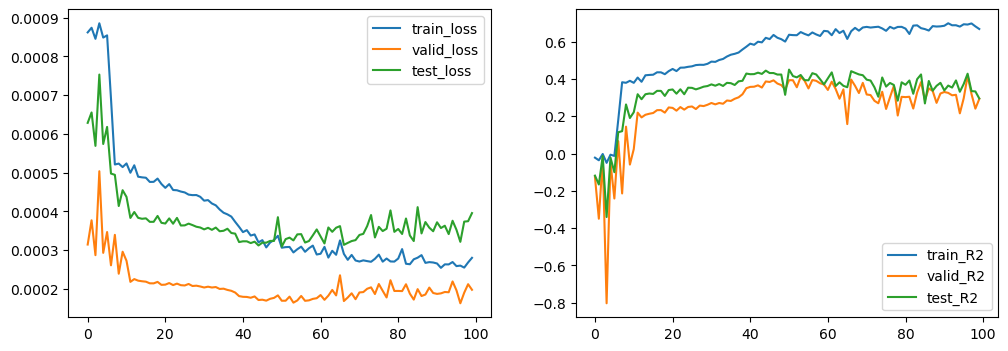

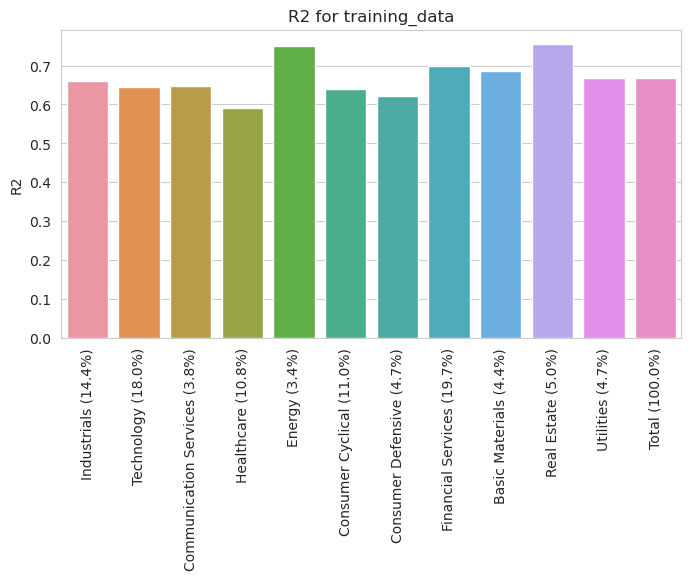

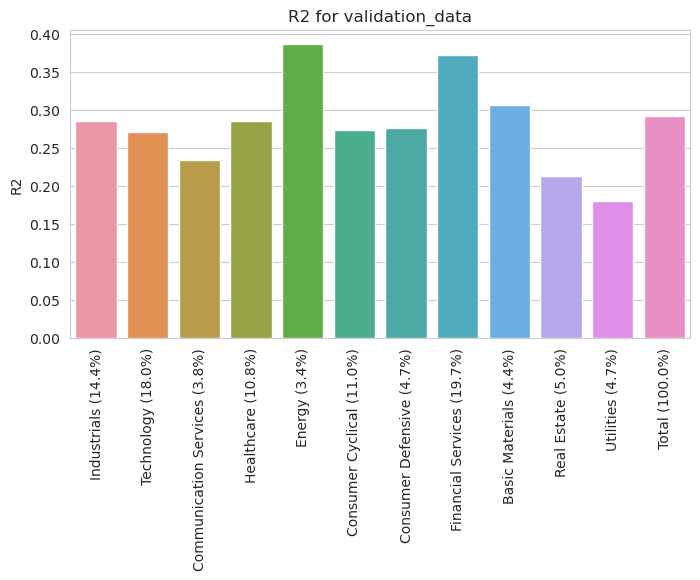

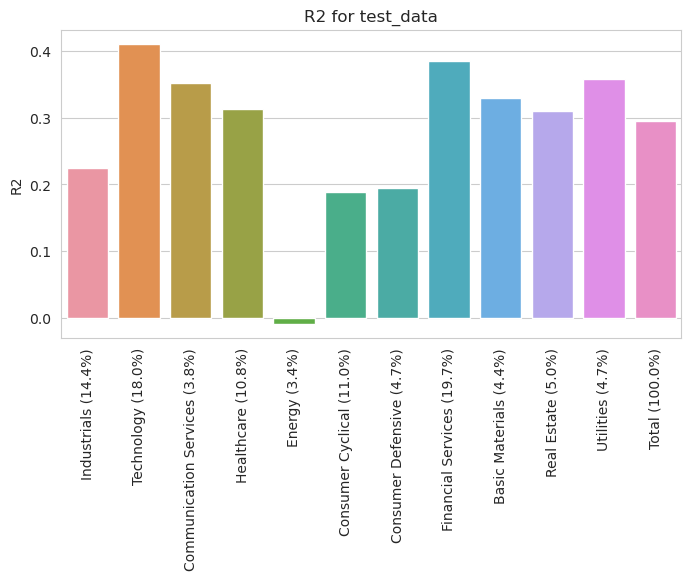

In [21]:
# ---------------- Run Extended model

dataloader_adv={
        'train' : train_dataloader_adv,
        'validation' : validation_dataloader_adv,
        'test' : test_dataloader_adv 
    }

dataset={
    'train' : training_data_adv,
    'validation' : validation_data_adv,
    'test' : test_data_adv
}


T_bkwd=10


# Model parameters

feature_vec_cr_dim=no_beta_factors
feature_vec_LSTM_dim=2*no_beta_factors+2
feature_vec_FF_dim=2*no_beta_factors+1+4

no_conv_layers=2
channel_out=81
kernel_size=2
seq_lgth=T_bkwd-1

cr_aggr_no_layers=5
cr_aggr_no_nodes=100
cr_output_vec_dim=10

LSTM_hidden_layer_dim=10
LSTM_no_layers=5
LSTM_no_nodes=100
LSTM_output_vec_dim=10

num_layers_FF=5
num_hidden_nodes_FF=200
P_dropout=0.2

epochs_E2=100

fname='run_extended'
dataloader=dataloader_adv
model_info="Model: EM2\n\n"
lr=5e-4
weight_decay=1e-9

run_E2_E2(T_bkwd,\
          feature_vec_cr_dim,\
          feature_vec_LSTM_dim,\
          feature_vec_FF_dim,\
          no_conv_layers,\
          channel_out,\
          kernel_size,\
          cr_aggr_no_layers,\
          cr_aggr_no_nodes,\
          cr_output_vec_dim,\
          LSTM_hidden_layer_dim,\
          LSTM_no_layers,\
          LSTM_no_nodes,\
          LSTM_output_vec_dim,\
          num_layers_FF,\
          num_hidden_nodes_FF,\
          P_dropout,\
          epochs_E2,\
          fname,\
          dataloader,\
          dataset,\
          model_info,\
          lr,\
          weight_decay)

## _Extended_ model CRF: Input $(\alpha ,\beta, \Delta F, F)$

This extended model takes all input data first to the convolutional layer block and then to the recurrent layer block and finally to the aggregator. 

In [22]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
#    if torch.backends.mps.is_available()
#    else "cpu"
)
print(f"Using {device} device")

# Define CRF model


class NN_CRF(nn.Module):
    def __init__(self,feature_vec_dim_cr,add_feature_vec_dim_FF,output_vec_dim,\
                 no_conv_layers,channel_out,kernel_size,seq_lgth,\
                 LSTM_hidden_layer_dim,aggr_num_layers,aggr_num_nodes,aggr_output_vec_dim,\
                 num_layers_FF,num_hidden_nodes_FF,P_dropout,activation=None,batch_first=True):

        super().__init__()

        # Set data

        self.feature_vec_dim=feature_vec_dim_cr
        self.add_feature_vec_dim_FF=add_feature_vec_dim_FF
        self.seq_lgth=seq_lgth

        if activation==None:

            self.activation=nn.ReLU()
            
        else:
            
            self.activation=activation
            
        # Convolution layer
            
        if no_conv_layers>0: 

            channel_out_lst=[]
            kernel_size_lst=[]
            for ii in range(no_conv_layers):
                channel_out_lst.append(channel_out)
                kernel_size_lst.append(kernel_size)

            layer_lst,C_out,L_out=gen_Conv1D_block(feature_vec_dim_cr,no_conv_layers,channel_out_lst,kernel_size_lst,seq_lgth)

            self.conv=nn.Sequential(*layer_lst)

            conv_dim_out=C_out
    
            conv_lgth=L_out
            
            self.flag_conv=True 
            
        else:
            
            conv_dim_out=feature_vec_dim_cr
            
            conv_lgth=self.seq_lgth
            
            self.flag_conv=False
            
        
        # LSTM layer
        
        if LSTM_hidden_layer_dim>0 and conv_dim_out>0: 
        

            LSTM_input_dim=conv_dim_out

            self.LSTM=nn.LSTM(input_size=LSTM_input_dim,hidden_size=LSTM_hidden_layer_dim,\
                    batch_first=batch_first) # LSTM x_t=(alpha,beta,d_factor,return)
            
            LSTM_output_dim=LSTM_hidden_layer_dim*conv_lgth
            
            self.flag_LSTM=True


        else:
            
            LSTM_output_dim=conv_dim_out*conv_lgth
            
            self.flag_LSTM=False

        
        # Create aggregator block
        
        if LSTM_output_dim>0:
        
            aggr_block=gen_FFN_block(feature_vec_dim=LSTM_output_dim,output_vec_dim=aggr_output_vec_dim,no_hidden_layers=aggr_num_layers,\
                               no_nodes_in_layer=aggr_num_nodes,P_dropout=P_dropout,activation=activation) 
        
                                    
            self.aggr_block=nn.Sequential(*aggr_block) 
            
            self.flag_aggr_layer=True
            
        else:
            aggr_output_vec_dim=0
            
            self.flag_aggr_laye=False 
            

        # FFN layer

        dim_FFN_input=aggr_output_vec_dim+add_feature_vec_dim_FF
            
        FFN=gen_FFN_block(feature_vec_dim=dim_FFN_input,output_vec_dim=output_vec_dim,no_hidden_layers=num_layers_FF,\
                               no_nodes_in_layer=num_hidden_nodes_FF,P_dropout=P_dropout,activation=activation) 
              
        
        self.FFN=nn.Sequential(*FFN)
            
    

    def forward(self, x):

        x_cr=x[:,:self.seq_lgth,:]
        x_model_t=x[:,self.seq_lgth,:self.add_feature_vec_dim_FF]
             
        
        if self.flag_conv: 
            
            x_cr=torch.permute(x_cr,(0,2,1)) 
                    
            x_cr=self.conv(x_cr)
            
            x_cr=torch.permute(x_cr,(0,2,1))             
        
        
        if self.flag_LSTM: 
                    
            x_LSTM,param=self.LSTM(x_cr)    
            
        else:
            
            x_LSTM=x_cr
            
        x_LSTM=torch.flatten(x_LSTM,start_dim=1)               
                        
            
        if self.flag_aggr_layer:
        
            x_LSTM=self.aggr_block(x_LSTM)
            
        
                                        
        x=torch.cat((x_LSTM,x_model_t),dim=1)
        
        return_vec=self.FFN(x)
                
        return return_vec


Using cuda device


### Run the CRF model (number of factors is 9)

In [23]:

def run_CRF(T_bkwd,\
        feature_vec_dim_cr,\
        add_feature_vec_dim_FF,\
        output_vec_dim,\
        no_conv_layers,\
        channel_out,\
        kernel_size,\
        LSTM_hidden_layer_dim,\
        aggr_num_layers,\
        aggr_num_nodes,\
        aggr_output_vec_dim,\
        num_layers_FF,\
        num_hidden_nodes_FF,\
        P_dropout,\
        dataloader_E2,
        data_set,\
        epochs_E2,\
        fname,\
        model_info="",\
        lr=5e-4,\
        weight_decay=1e-9):
    
    # -----  Model specification

    seq_lgth=T_bkwd-1

    # Model initialisation 

    model_CRF_E2=NN_CRF(feature_vec_dim_cr,add_feature_vec_dim_FF,output_vec_dim,\
                 no_conv_layers,channel_out,kernel_size,seq_lgth,\
                 LSTM_hidden_layer_dim,aggr_num_layers,aggr_num_nodes,aggr_output_vec_dim,\
                 num_layers_FF,num_hidden_nodes_FF,P_dropout).to(device)

    print(model_CRF_E2)

    loss_fn_CRF_E2 = nn.MSELoss()
    optimizer_CRF_E2 = torch.optim.Adam(model_CRF_E2.parameters(), lr=lr,weight_decay=weight_decay)

    # Run extended CRF factor model 
    
    run_model(model_CRF_E2,optimizer_CRF_E2,loss_fn_CRF_E2,epochs_E2,dataloader_E2,fname,label=model_info)

    # Calculate R2 on sectors

    from_id,to_id=0,training_set_no_data-1
    c_sec_stat(model_CRF_E2,loss_fn_CRF_E2,data_set['train'],sector_name_fname,from_id,to_id,fname,'training_data')

    from_id,to_id=training_set_no_data,training_set_no_data+validation_set_no_data-1
    c_sec_stat(model_CRF_E2,loss_fn_CRF_E2,data_set['validation'],sector_name_fname,from_id,to_id,fname,'validation_data')

    from_id,to_id=training_set_no_data+validation_set_no_data,training_set_no_data+validation_set_no_data+test_set_no_data-1
    c_sec_stat(model_CRF_E2,loss_fn_CRF_E2,data_set['test'],sector_name_fname,from_id,to_id,fname,'test_data')

NN_CRF(
  (activation): ReLU()
  (conv): Sequential(
    (0): Conv1d(20, 81, kernel_size=(2,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(81, 81, kernel_size=(2,), stride=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (LSTM): LSTM(81, 10, batch_first=True)
  (aggr_block): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_sta

test R^2=0.46449244022369385

Epoch 41
-------------------------------
training R^2=0.4957669973373413

validation R^2=0.32790178060531616

test R^2=0.4747517704963684

Epoch 42
-------------------------------
training R^2=0.486042857170105

validation R^2=0.3201637864112854

test R^2=0.4629746079444885

Epoch 43
-------------------------------
training R^2=0.4897197484970093

validation R^2=0.32521820068359375

test R^2=0.4676321744918823

Epoch 44
-------------------------------
training R^2=0.49355989694595337

validation R^2=0.3214879035949707

test R^2=0.4672008156776428

Epoch 45
-------------------------------
training R^2=0.48037970066070557

validation R^2=0.306554913520813

test R^2=0.45567142963409424

Epoch 46
-------------------------------
training R^2=0.49616682529449463

validation R^2=0.32695502042770386

test R^2=0.4742259979248047

Epoch 47
-------------------------------
training R^2=0.4766249656677246

validation R^2=0.2987118363380432

test R^2=0.45034486055374146

test R^2=0.45110058784484863

Epoch 100
-------------------------------
training R^2=0.48672783374786377

validation R^2=0.3093903660774231

test R^2=0.45671409368515015

Pareto optimal solution: iter*: 24 training_R2*: 0.499930 validation_R2*: 0.329789 test_R2*: 0.479445


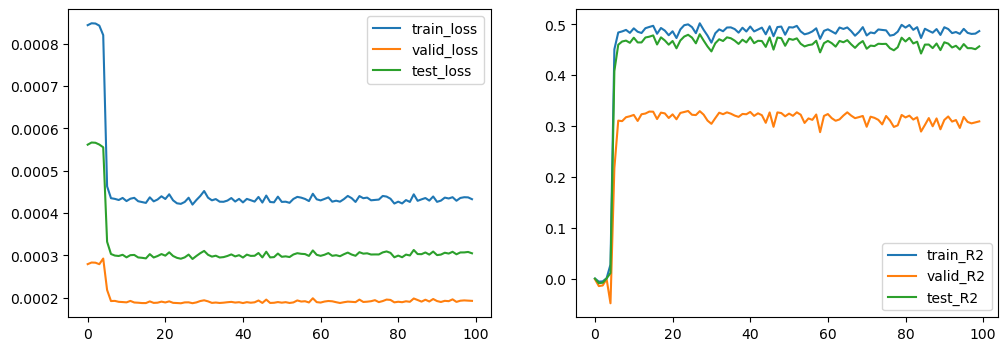

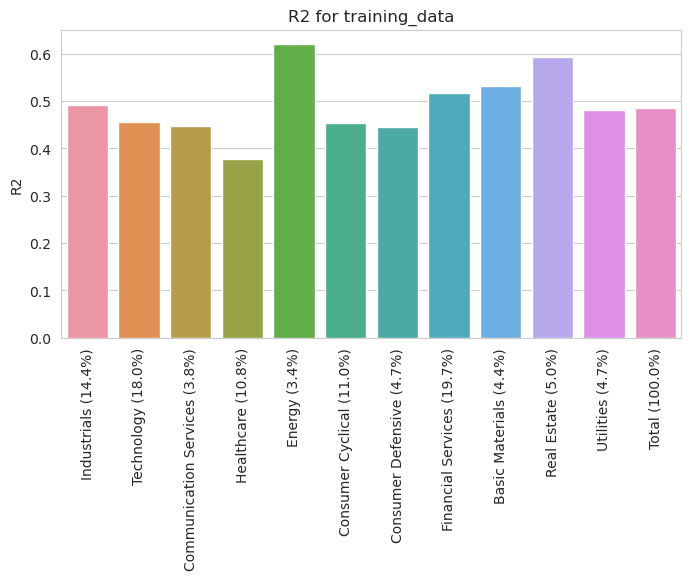

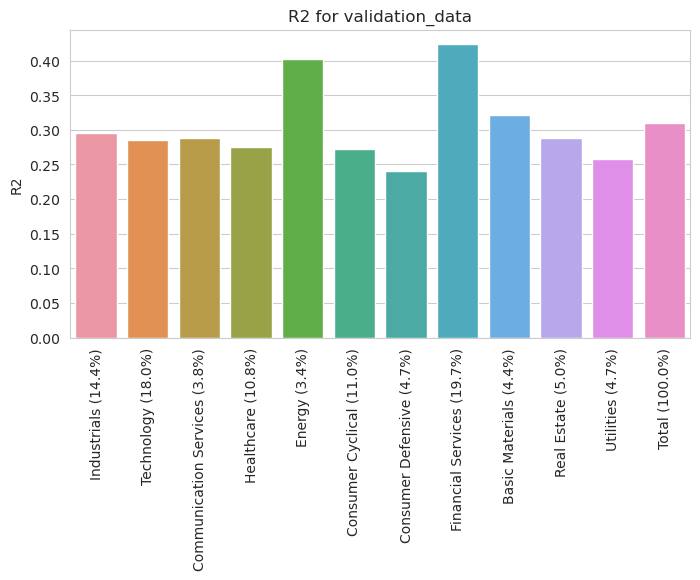

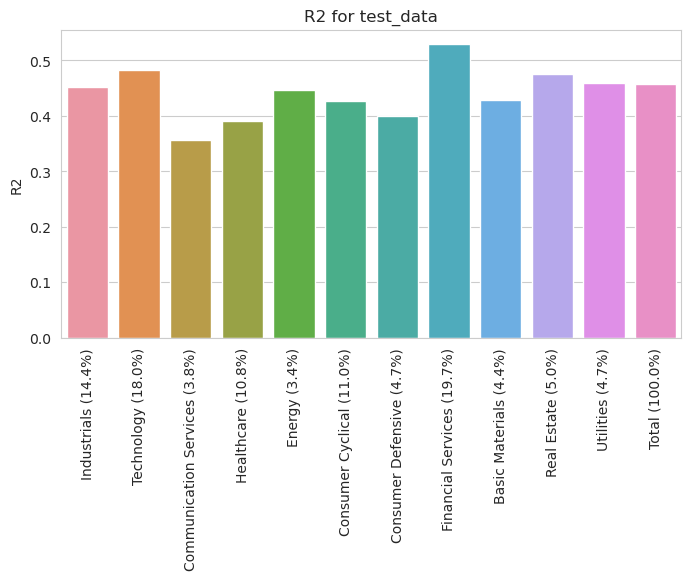

In [24]:
# Run CRF model

dataloader_E2={
    'train' : train_dataloader_E2,
    'validation' : validation_dataloader_E2,
    'test' : test_dataloader_E2 
}

data_set={
    'train' : training_data_E2,
    'validation' : validation_data_E2,
    'test' : test_data_E2
}

run_CRF(T_bkwd=10,\
        feature_vec_dim_cr=2*no_beta_factors+2,\
        add_feature_vec_dim_FF=no_beta_factors+5,\
        output_vec_dim=1,\
        no_conv_layers=2,\
        channel_out=81,\
        kernel_size=2,\
        LSTM_hidden_layer_dim=10,\
        aggr_num_layers=4,\
        aggr_num_nodes=100,\
        aggr_output_vec_dim=10,\
        num_layers_FF=4,\
        num_hidden_nodes_FF=200,\
        P_dropout=0.2,\
        dataloader_E2=dataloader_E2,\
        data_set=data_set,\
        epochs_E2=100,\
        fname='run_CRF',\
        model_info="Model: CRF\n\n",\
        lr=5e-4,\
        weight_decay=1e-9)

# Autoencoder

In [25]:
class AE_data_base(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        self.no_data=(to_id-from_id+1)

        dim_feature_vec=(no_beta_factors+no_assets)  # Factor and asset returns

        self.input_data_np=np.zeros((self.no_data,dim_feature_vec),dtype=np.float32)

        self.output_data_np=np.zeros((self.no_data,no_assets),dtype=np.float32)

        p_input_data=0

        for ii in range(from_id,to_id+1):
            self.input_data_np[p_input_data,:]=data.return_data_np[ii,:]
            self.output_data_np[p_input_data,:]=data.return_data_np[ii,no_beta_factors:]
            p_input_data+=1

        self.data=data

        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np) 

        super().__init__(input_data_t,output_data_t)
        
    def _assign_io_data(self,i_data_t,o_data_t):
        
        self.input_data_t,self.output_data_t=i_data_t,o_data_t

    def filter_data(self,sec_id_lst,from_id,to_id):

        pass
        


# Create data loaders.

training_data_AE=AE_data_base(data,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_AE=AE_data_base(data,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_AE=AE_data_base(data,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

batch_size_AE=50

train_dataloader_AE = DataLoader(training_data_AE,batch_size=batch_size_AE,shuffle=True)
validation_dataloader_AE=DataLoader(validation_data_AE,batch_size=batch_size_AE,shuffle=True)
test_dataloader_AE = DataLoader(test_data_AE,batch_size=batch_size_AE,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_AE.__len__()}')
print(f'number of validation batches {validation_dataloader_AE.__len__()}')
print(f'number of test batches {test_dataloader_AE.__len__()}')

# train_features, train_output = next(iter(train_dataloader_base))
# validation_features, validation_output = next(iter(validation_dataloader_base))
# test_features,test_output=next(iter(test_dataloader_base))


number of training batches 28
number of validation batches 28
number of test batches 28


In [26]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
#    if torch.backends.mps.is_available()
#    else "cpu"
)
print(f"Using {device} device")

# Autoencoder model


class NN_AE(nn.Module):
    def __init__(self,encoder_layer_lst,decoder_layer_lst,P_dropout=0.1,activation=None):

        super().__init__()
        
        FFN=gen_AE_block(encoder_layer_lst,P_dropout,activation)
        
        self.encoder=nn.Sequential(*FFN)
        
        FFN=gen_AE_block(decoder_layer_lst,P_dropout,activation)
        
        self.decoder=nn.Sequential(*FFN)
            
    def forward(self,x):
        
        y=self.encoder(x)
        
        z=self.decoder(y)
        
        return z

Using cuda device


In [27]:
def gen_AE_data(model_AE,data_AE,depr_param=0.005):
    """ generate intrinsic factor returns and (alpha,beta) parameters from the adaptive model"""
    
    x=data_AE.input_data_t.to(device)
    
    ifactor_returns_t=model_AE.encoder(x)
    
    
    x=ifactor_returns_t.to(device="cpu")
    ifactor_returns_np=x.detach().numpy()
    ofactor_returns_np=data_AE.output_data_t.numpy()
    
    (no_data,no_factors)=ifactor_returns_np.shape
    
    start_window=3*no_factors
    
    return_data_np=np.concatenate((ifactor_returns_np,ofactor_returns_np),axis=1)
    
    model=invlib.asset_model()

    factor_weights,prediction_error,stat_param_var,err_var=model.calibrate_adaptive_linear_model(\
                                                                   return_data_np,no_factors,\
                                                                   depr_param=depr_param,init_window=start_window)
    
    # Calculate intrinsic factor levels
    
    ifactor_levels_np=torch.cumsum(data_AE.input_data_t[:,:no_factors],dim=1).numpy()
    
    return return_data_np,factor_weights,prediction_error, ifactor_levels_np
        


### Run the linear autoencoder (intrinsic dimensioin is 20)

In [28]:
# ******************** Flag that controls if new data related to AE factors are generated

flag_generate_AE_factor_info=False # If true data new AE factor related data are generated

# *********************


# -----  Model specification AE for the linear case

def run_AE():

    # Model parameters
    
    no_intrinsic_factors=20

    encoder_layer_lst=[no_beta_factors+no_assets,no_intrinsic_factors]
    decoder_layer_lst=[no_intrinsic_factors,no_assets]
    
    P_dropout=0.1

    # Model initialisation 

#    model_AE=NN_AE(encoder_layer_lst,decoder_layer_lst,P_dropout,activation=nn.ReLU()).to(device)
    model_AE=NN_AE(encoder_layer_lst,decoder_layer_lst,P_dropout,activation=None).to(device) # linear activation function

    print(model_AE)

    loss_fn_AE = nn.MSELoss()
    optimizer_AE = torch.optim.Adam(model_AE.parameters(), lr=1e-3,weight_decay=1e-9)

    # Run simple factor model with factor changes and (alpha,beta) as input and output is return

    epochs_AE=1000

    fname='run_AE'


    dataloader_AE={
        'train' : train_dataloader_AE,
        'validation' : validation_dataloader_AE,
        'test' : test_dataloader_AE 
    }

    model_info="Model: AE\n dataset: AE\n run_id: AE\n\n"

    run_model(model_AE,optimizer_AE,loss_fn_AE,epochs_AE,dataloader_AE,fname,label=model_info)
    
    if flag_generate_AE_factor_info: 
    
        # generate intrinsic factors and (alpha,beta) parammeters and error vector and save to files    
    
        depr_param=0.005
    
        ifactor_fn='ifactor_return'
    
        all_data_AE=AE_data_base(data,from_id=0,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1) 
    
        all_data=DataLoader(all_data_AE,batch_size=1,shuffle=False)
    
        ireturn_levels,ifactor_weights,prediction_error,ifactor_levels=gen_AE_data(model_AE,all_data_AE,depr_param)
    
    
        #--- save data
    
        factor_weights_fn='intr_factor_weights'
        prediction_error_fn='intr_pred_error'    
        factor_levels_fn='intr_factor_levels'    
        return_levels_fn='intr_return_levels'
    
        # reshaping factor weights
    
        loader=invlib.asset_data()

        (t_data,n_factors,n_comp)=ifactor_weights.shape
        n_data_fw=t_data*n_factors*n_comp

        loader.save_return_data_to_file(factor_weights_fn,np.reshape(ifactor_weights,n_data_fw))    
        loader.save_return_data_to_file(prediction_error_fn,prediction_error)
        loader.save_return_data_to_file(factor_levels_fn,ifactor_levels)
        loader.save_return_data_to_file(return_levels_fn,ireturn_levels)
    
        # print info
    
        print(f'ifactor_weights {ifactor_weights.shape}')
        print(f'prediction_error {prediction_error.shape}')
        print(f'ireturn_levels {ifactor_levels.shape}')
        print(f'ifactor_returns {ireturn_levels.shape}')


NN_AE(
  (encoder): Sequential(
    (0): Linear(in_features=647, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=638, bias=True)
  )
)
Epoch 1
-------------------------------
training R^2=-10.079812049865723

validation R^2=-30.199155807495117

test R^2=-15.055013656616211

Epoch 2
-------------------------------
training R^2=-2.196101188659668

validation R^2=-6.715168476104736

test R^2=-3.394575595855713

Epoch 3
-------------------------------
training R^2=-0.1672147512435913

validation R^2=-0.7028461694717407

test R^2=-0.31636548042297363

Epoch 4
-------------------------------
training R^2=0.1329140067100525

validation R^2=-0.023579835891723633

test R^2=0.07969743013381958

Epoch 5
-------------------------------
training R^2=0.23635470867156982

validation R^2=0.08522462844848633

test R^2=0.1800522804260254

Epoch 6
-------------------------------
training R^2=0.31440603733062744

validation R^2=0.13179099559783936

tes

training R^2=0.5312336683273315

validation R^2=0.30264556407928467

test R^2=0.4482561945915222

Epoch 63
-------------------------------
training R^2=0.5332760214805603

validation R^2=0.3066853880882263

test R^2=0.4498502016067505

Epoch 64
-------------------------------
training R^2=0.5332666635513306

validation R^2=0.3055106997489929

test R^2=0.4497829079627991

Epoch 65
-------------------------------
training R^2=0.5335400700569153

validation R^2=0.3057771325111389

test R^2=0.44717442989349365

Epoch 66
-------------------------------
training R^2=0.5372681617736816

validation R^2=0.3066672682762146

test R^2=0.45115041732788086

Epoch 67
-------------------------------
training R^2=0.5397325754165649

validation R^2=0.30711740255355835

test R^2=0.454551637172699

Epoch 68
-------------------------------
training R^2=0.5387154817581177

validation R^2=0.3098222613334656

test R^2=0.45550537109375

Epoch 69
-------------------------------
training R^2=0.5418368577957153



training R^2=0.5768604278564453

validation R^2=0.3387700915336609

test R^2=0.4817469120025635

Epoch 126
-------------------------------
training R^2=0.5773205161094666

validation R^2=0.3381802439689636

test R^2=0.48475921154022217

Epoch 127
-------------------------------
training R^2=0.5826036930084229

validation R^2=0.3376910090446472

test R^2=0.4852293133735657

Epoch 128
-------------------------------
training R^2=0.5813493728637695

validation R^2=0.33882981538772583

test R^2=0.48182743787765503

Epoch 129
-------------------------------
training R^2=0.5783490538597107

validation R^2=0.3401679992675781

test R^2=0.4851987957954407

Epoch 130
-------------------------------
training R^2=0.5790963768959045

validation R^2=0.3383036255836487

test R^2=0.4852811098098755

Epoch 131
-------------------------------
training R^2=0.5819551944732666

validation R^2=0.3403577208518982

test R^2=0.48516273498535156

Epoch 132
-------------------------------
training R^2=0.57877963

training R^2=0.6009155511856079

validation R^2=0.3510552644729614

test R^2=0.4952431917190552

Epoch 189
-------------------------------
training R^2=0.5977540612220764

validation R^2=0.34745973348617554

test R^2=0.4923585057258606

Epoch 190
-------------------------------
training R^2=0.5965726375579834

validation R^2=0.3501586318016052

test R^2=0.4976685643196106

Epoch 191
-------------------------------
training R^2=0.5969231128692627

validation R^2=0.3508288860321045

test R^2=0.4927435517311096

Epoch 192
-------------------------------
training R^2=0.5968913435935974

validation R^2=0.3515923023223877

test R^2=0.49363893270492554

Epoch 193
-------------------------------
training R^2=0.5976700782775879

validation R^2=0.35016047954559326

test R^2=0.49299830198287964

Epoch 194
-------------------------------
training R^2=0.6006678342819214

validation R^2=0.34974348545074463

test R^2=0.4934937357902527

Epoch 195
-------------------------------
training R^2=0.6010031

training R^2=0.6045078039169312

validation R^2=0.3520418405532837

test R^2=0.49481916427612305

Epoch 252
-------------------------------
training R^2=0.6080496311187744

validation R^2=0.35460710525512695

test R^2=0.49650704860687256

Epoch 253
-------------------------------
training R^2=0.6048059463500977

validation R^2=0.35356682538986206

test R^2=0.49580609798431396

Epoch 254
-------------------------------
training R^2=0.6058357954025269

validation R^2=0.35276418924331665

test R^2=0.5019850730895996

Epoch 255
-------------------------------
training R^2=0.6052883863449097

validation R^2=0.35572028160095215

test R^2=0.5033957958221436

Epoch 256
-------------------------------
training R^2=0.6061959266662598

validation R^2=0.35502344369888306

test R^2=0.4955672025680542

Epoch 257
-------------------------------
training R^2=0.6068044304847717

validation R^2=0.3542611002922058

test R^2=0.49720507860183716

Epoch 258
-------------------------------
training R^2=0.609

training R^2=0.6110426187515259

validation R^2=0.357552170753479

test R^2=0.49789541959762573

Epoch 314
-------------------------------
training R^2=0.6107097268104553

validation R^2=0.35700976848602295

test R^2=0.4971640110015869

Epoch 315
-------------------------------
training R^2=0.6089509725570679

validation R^2=0.3567134737968445

test R^2=0.4982006549835205

Epoch 316
-------------------------------
training R^2=0.6117140054702759

validation R^2=0.35848867893218994

test R^2=0.4992225766181946

Epoch 317
-------------------------------
training R^2=0.6112070679664612

validation R^2=0.35813653469085693

test R^2=0.498749315738678

Epoch 318
-------------------------------
training R^2=0.6112313270568848

validation R^2=0.3578200340270996

test R^2=0.4993351697921753

Epoch 319
-------------------------------
training R^2=0.6117033362388611

validation R^2=0.35703861713409424

test R^2=0.49791717529296875

Epoch 320
-------------------------------
training R^2=0.61171054

training R^2=0.6114084720611572

validation R^2=0.3590658903121948

test R^2=0.49918103218078613

Epoch 377
-------------------------------
training R^2=0.6116777062416077

validation R^2=0.3606676459312439

test R^2=0.4990310072898865

Epoch 378
-------------------------------
training R^2=0.6101374626159668

validation R^2=0.35734760761260986

test R^2=0.5060775876045227

Epoch 379
-------------------------------
training R^2=0.6091363430023193

validation R^2=0.35737574100494385

test R^2=0.4988822340965271

Epoch 380
-------------------------------
training R^2=0.6106785535812378

validation R^2=0.3592596650123596

test R^2=0.5007461309432983

Epoch 381
-------------------------------
training R^2=0.6117703318595886

validation R^2=0.3606814742088318

test R^2=0.4990697503089905

Epoch 382
-------------------------------
training R^2=0.6112356185913086

validation R^2=0.36002594232559204

test R^2=0.4992687702178955

Epoch 383
-------------------------------
training R^2=0.61462652

training R^2=0.6125935316085815

validation R^2=0.3601492643356323

test R^2=0.5006726980209351

Epoch 438
-------------------------------
training R^2=0.6133760809898376

validation R^2=0.36069542169570923

test R^2=0.4990262985229492

Epoch 439
-------------------------------
training R^2=0.6148936748504639

validation R^2=0.3604133725166321

test R^2=0.5069283843040466

Epoch 440
-------------------------------
training R^2=0.6130951642990112

validation R^2=0.3596709370613098

test R^2=0.5010496377944946

Epoch 441
-------------------------------
training R^2=0.6128404140472412

validation R^2=0.36111676692962646

test R^2=0.49938124418258667

Epoch 442
-------------------------------
training R^2=0.6144598126411438

validation R^2=0.36026430130004883

test R^2=0.49917489290237427

Epoch 443
-------------------------------
training R^2=0.6148738861083984

validation R^2=0.3605496287345886

test R^2=0.4997026324272156

Epoch 444
-------------------------------
training R^2=0.6152625

training R^2=0.6151415109634399

validation R^2=0.36053532361984253

test R^2=0.5004779100418091

Epoch 501
-------------------------------
training R^2=0.6138635277748108

validation R^2=0.36039555072784424

test R^2=0.5001185536384583

Epoch 502
-------------------------------
training R^2=0.6138546466827393

validation R^2=0.366477906703949

test R^2=0.5016225576400757

Epoch 503
-------------------------------
training R^2=0.6150109171867371

validation R^2=0.3603736162185669

test R^2=0.5023475885391235

Epoch 504
-------------------------------
training R^2=0.6142442226409912

validation R^2=0.36298084259033203

test R^2=0.5019140243530273

Epoch 505
-------------------------------
training R^2=0.6168841123580933

validation R^2=0.3621697425842285

test R^2=0.5012890100479126

Epoch 506
-------------------------------
training R^2=0.6164753437042236

validation R^2=0.36208707094192505

test R^2=0.500770092010498

Epoch 507
-------------------------------
training R^2=0.6181442141

training R^2=0.6123835444450378

validation R^2=0.3617677688598633

test R^2=0.49688786268234253

Epoch 564
-------------------------------
training R^2=0.6142764687538147

validation R^2=0.36078768968582153

test R^2=0.5000723600387573

Epoch 565
-------------------------------
training R^2=0.6152991652488708

validation R^2=0.36180752515792847

test R^2=0.5012552738189697

Epoch 566
-------------------------------
training R^2=0.6149927377700806

validation R^2=0.363849937915802

test R^2=0.5048820972442627

Epoch 567
-------------------------------
training R^2=0.6155585646629333

validation R^2=0.3626343011856079

test R^2=0.5017691850662231

Epoch 568
-------------------------------
training R^2=0.616270899772644

validation R^2=0.3627347946166992

test R^2=0.5028815269470215

Epoch 569
-------------------------------
training R^2=0.6165956854820251

validation R^2=0.3633419871330261

test R^2=0.5019652843475342

Epoch 570
-------------------------------
training R^2=0.61907374858

test R^2=0.50263911485672

Epoch 626
-------------------------------
training R^2=0.61676424741745

validation R^2=0.3653264045715332

test R^2=0.5023760795593262

Epoch 627
-------------------------------
training R^2=0.6159680485725403

validation R^2=0.36661118268966675

test R^2=0.5090348720550537

Epoch 628
-------------------------------
training R^2=0.6180391311645508

validation R^2=0.3630657196044922

test R^2=0.503130316734314

Epoch 629
-------------------------------
training R^2=0.6168684959411621

validation R^2=0.36380285024642944

test R^2=0.5016628503799438

Epoch 630
-------------------------------
training R^2=0.6179553866386414

validation R^2=0.36391592025756836

test R^2=0.5029891729354858

Epoch 631
-------------------------------
training R^2=0.6178275346755981

validation R^2=0.3642385005950928

test R^2=0.5028136968612671

Epoch 632
-------------------------------
training R^2=0.6177393198013306

validation R^2=0.3638607859611511

test R^2=0.5024293065071106



training R^2=0.6153100728988647

validation R^2=0.36528462171554565

test R^2=0.5024470090866089

Epoch 688
-------------------------------
training R^2=0.6159380674362183

validation R^2=0.36435794830322266

test R^2=0.5021135807037354

Epoch 689
-------------------------------
training R^2=0.6164987087249756

validation R^2=0.36508458852767944

test R^2=0.502805233001709

Epoch 690
-------------------------------
training R^2=0.6180778741836548

validation R^2=0.3639313578605652

test R^2=0.5017386674880981

Epoch 691
-------------------------------
training R^2=0.6210308074951172

validation R^2=0.36495012044906616

test R^2=0.5036458969116211

Epoch 692
-------------------------------
training R^2=0.6180434226989746

validation R^2=0.3642617464065552

test R^2=0.504433274269104

Epoch 693
-------------------------------
training R^2=0.6166953444480896

validation R^2=0.36214280128479004

test R^2=0.5013620853424072

Epoch 694
-------------------------------
training R^2=0.615879833

training R^2=0.6186627745628357

validation R^2=0.364332377910614

test R^2=0.503621518611908

Epoch 750
-------------------------------
training R^2=0.6165244579315186

validation R^2=0.3653925657272339

test R^2=0.5022302269935608

Epoch 751
-------------------------------
training R^2=0.6161296367645264

validation R^2=0.3641777038574219

test R^2=0.5027901530265808

Epoch 752
-------------------------------
training R^2=0.6183059215545654

validation R^2=0.3657950162887573

test R^2=0.5011366605758667

Epoch 753
-------------------------------
training R^2=0.6177563667297363

validation R^2=0.36414241790771484

test R^2=0.5022643804550171

Epoch 754
-------------------------------
training R^2=0.61704421043396

validation R^2=0.36426234245300293

test R^2=0.5017281770706177

Epoch 755
-------------------------------
training R^2=0.6172147989273071

validation R^2=0.36375558376312256

test R^2=0.5022658109664917

Epoch 756
-------------------------------
training R^2=0.6168013811111

training R^2=0.6163333058357239

validation R^2=0.36489373445510864

test R^2=0.5028989315032959

Epoch 809
-------------------------------
training R^2=0.6178514957427979

validation R^2=0.36549830436706543

test R^2=0.5019440650939941

Epoch 810
-------------------------------
training R^2=0.6155129075050354

validation R^2=0.36501091718673706

test R^2=0.5013331174850464

Epoch 811
-------------------------------
training R^2=0.6179036498069763

validation R^2=0.364510178565979

test R^2=0.5025793313980103

Epoch 812
-------------------------------
training R^2=0.6170412302017212

validation R^2=0.3657125234603882

test R^2=0.5014895796775818

Epoch 813
-------------------------------
training R^2=0.6175943613052368

validation R^2=0.3646394610404968

test R^2=0.502082109451294

Epoch 814
-------------------------------
training R^2=0.6170839667320251

validation R^2=0.3639233708381653

test R^2=0.5035185813903809

Epoch 815
-------------------------------
training R^2=0.61575317382

training R^2=0.6181583404541016

validation R^2=0.3650176525115967

test R^2=0.5021051168441772

Epoch 871
-------------------------------
training R^2=0.6166344881057739

validation R^2=0.3640482425689697

test R^2=0.49992722272872925

Epoch 872
-------------------------------
training R^2=0.6192237138748169

validation R^2=0.36552250385284424

test R^2=0.5012972354888916

Epoch 873
-------------------------------
training R^2=0.6178314685821533

validation R^2=0.3627435564994812

test R^2=0.5021436214447021

Epoch 874
-------------------------------
training R^2=0.6111546754837036

validation R^2=0.3615983724594116

test R^2=0.49768370389938354

Epoch 875
-------------------------------
training R^2=0.6166767477989197

validation R^2=0.3633708953857422

test R^2=0.4995763897895813

Epoch 876
-------------------------------
training R^2=0.6131817102432251

validation R^2=0.3611554503440857

test R^2=0.4973464012145996

Epoch 877
-------------------------------
training R^2=0.617639780

training R^2=0.6170804500579834

validation R^2=0.36554884910583496

test R^2=0.5017954111099243

Epoch 933
-------------------------------
training R^2=0.6166528463363647

validation R^2=0.3628535866737366

test R^2=0.5019159913063049

Epoch 934
-------------------------------
training R^2=0.6162307858467102

validation R^2=0.3639014959335327

test R^2=0.5003807544708252

Epoch 935
-------------------------------
training R^2=0.617412805557251

validation R^2=0.3648861050605774

test R^2=0.5030149221420288

Epoch 936
-------------------------------
training R^2=0.619437575340271

validation R^2=0.36558932065963745

test R^2=0.5020104050636292

Epoch 937
-------------------------------
training R^2=0.6171271800994873

validation R^2=0.36530935764312744

test R^2=0.5035181641578674

Epoch 938
-------------------------------
training R^2=0.6201398372650146

validation R^2=0.36529701948165894

test R^2=0.5020028948783875

Epoch 939
-------------------------------
training R^2=0.6162946820

training R^2=0.6164945363998413

validation R^2=0.3656049370765686

test R^2=0.5023219585418701

Epoch 995
-------------------------------
training R^2=0.6181313991546631

validation R^2=0.3631249666213989

test R^2=0.5014752149581909

Epoch 996
-------------------------------
training R^2=0.6174224615097046

validation R^2=0.36578863859176636

test R^2=0.5007114410400391

Epoch 997
-------------------------------
training R^2=0.6197335124015808

validation R^2=0.3648541569709778

test R^2=0.502353310585022

Epoch 998
-------------------------------
training R^2=0.6163280606269836

validation R^2=0.36543118953704834

test R^2=0.502184271812439

Epoch 999
-------------------------------
training R^2=0.6191993951797485

validation R^2=0.36439430713653564

test R^2=0.5071048736572266

Epoch 1000
-------------------------------
training R^2=0.6165515184402466

validation R^2=0.36631447076797485

test R^2=0.5018426179885864

Pareto optimal solution: iter*: 862 training_R2*: 0.617623 validat

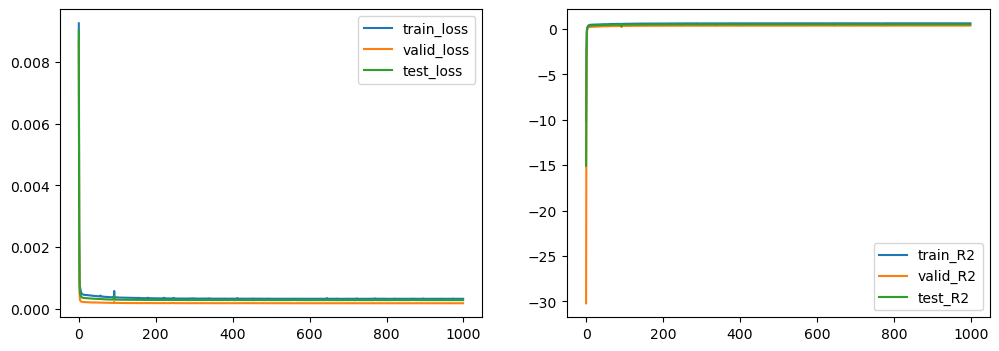

In [29]:
# run AE model

run_AE()

### AE batch run

The batch runs (linear and non-linear AE) can be activated changing the flags below.

In [30]:

# -----  Model specification AE

def run_AE_batch(no_intrinsic_factors,encoder_layer_lst,decoder_layer_lst,P_dropout,activation,\
                epochs_AE,fname,lr=1e-3,weight_decay=1e-9):



    # Model initialisation 

    model_AE=NN_AE(encoder_layer_lst,decoder_layer_lst,P_dropout,activation=activation).to(device) 

    print(model_AE)

    loss_fn_AE = nn.MSELoss()
    optimizer_AE = torch.optim.Adam(model_AE.parameters(), lr=lr,weight_decay=weight_decay)

    # Run simple factor model with factor changes and (alpha,beta) as input and output is return


    dataloader_AE={
        'train' : train_dataloader_AE,
        'validation' : validation_dataloader_AE,
        'test' : test_dataloader_AE 
    }

    model_info="Model: AE\n dataset: AE\n run_id: AE\n\n"+'no_intrinsic_factors: '+str(no_intrinsic_factors)+'\n\n'

    run_model(model_AE,optimizer_AE,loss_fn_AE,epochs_AE,dataloader_AE,fname,label=model_info)


In [31]:
# AE batch run

# **********************

flag_run_AE_batch=False

# **********************

if flag_run_AE_batch: 

    encoder_layer_lst=[no_beta_factors+no_assets,3]
    decoder_layer_lst=[3,no_assets]

    run_AE_batch(no_intrinsic_factors=3,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_3',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,7]
    decoder_layer_lst=[7,no_assets]

    run_AE_batch(no_intrinsic_factors=7,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_7',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,11]
    decoder_layer_lst=[11,no_assets]

    run_AE_batch(no_intrinsic_factors=11,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_11',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,15]
    decoder_layer_lst=[15,no_assets]

    run_AE_batch(no_intrinsic_factors=15,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_15',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,20]
    decoder_layer_lst=[20,no_assets]

    run_AE_batch(no_intrinsic_factors=20,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_20',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,30]
    decoder_layer_lst=[30,no_assets]

    run_AE_batch(no_intrinsic_factors=30,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_30',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50]
    decoder_layer_lst=[50,no_assets]

    run_AE_batch(no_intrinsic_factors=50,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_50',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,100]
    decoder_layer_lst=[100,no_assets]

    run_AE_batch(no_intrinsic_factors=100,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_100',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,200]
    decoder_layer_lst=[200,no_assets]

    run_AE_batch(no_intrinsic_factors=200,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_200',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,300]
    decoder_layer_lst=[300,no_assets]

    run_AE_batch(no_intrinsic_factors=300,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_300',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,600]
    decoder_layer_lst=[600,no_assets]

    run_AE_batch(no_intrinsic_factors=600,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_600',lr=1e-3,weight_decay=1e-9)



In [32]:
# AE batch runs for non-linear activation

# **********************

flag_run_AE_nl_batch=False

# **********************

if flag_run_AE_nl_batch:

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,3]
    decoder_layer_lst=[3,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=3,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_3',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,7]
    decoder_layer_lst=[7,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=7,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_7',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,11]
    decoder_layer_lst=[11,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=11,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_11',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,15]
    decoder_layer_lst=[15,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=15,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_15',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,20]
    decoder_layer_lst=[20,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=20,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_20',lr=1e-3,weight_decay=1e-9)

# Non-linear Neural network factor models where number of AE factors is 20

In the following the _base_ model and the _extended_ model where 20 AE factors is applied examplified with a configuration that is the most promising.

In [33]:
factor_levels_fname="intr_factor_levels" # File name on factor levels matching factor weights

factor_weights_fname="intr_factor_weights" # File name of factor weights from adaptive model

prediction_error_fname="intr_pred_error" # File name of prediction errors from adaptive model

return_levels_fname="intr_return_levels" # File name for return levels 

ticker_sector_np_fname="ticker_sector_data003" # File name for numpy stucture with sector id

factor_order_fname="factor_order_data.txt" # File with of factor names in adaptive model

asset_order_fname="asset_order_data.txt" # File with asset names in adaptive model

sector_name_fname="sector_id.txt"  # File with sector names

no_beta_factors=20  # Number of beta factors

no_assets=638 # Number of assets

no_dataset=4134  # Number of data

batch_size = 1000  # Batch size

# training_set_no_data=478 # Number of data in training set

# validation_set_no_data=478 # Number of data in validation set

# test_set_no_data=478 # Number of data in test set

training_set_no_data=1378 # Number of data in training set

validation_set_no_data=1378 # Number of data in validation set

test_set_no_data=1378 # Number of data in test set

In [34]:
data_i=database(factor_levels_fname,factor_weights_fname,prediction_error_fname,return_levels_fname,ticker_sector_np_fname)


##  _Base_ model where number of AE factors is 20

In [35]:
# Create data loaders.

training_data_b2_i=market_data_base2(data_i,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_b2_i=market_data_base2(data_i,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_b2_i=market_data_base2(data_i,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_b2_i = DataLoader(training_data_b2_i, batch_size=batch_size,shuffle=True)
validation_dataloader_b2_i=DataLoader(validation_data_b2_i, batch_size=batch_size,shuffle=True)
test_dataloader_b2_i = DataLoader(test_data_b2_i, batch_size=batch_size,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_b2_i.__len__()}')
print(f'number of validation batches {validation_dataloader_b2_i.__len__()}')
print(f'number of test batches {test_dataloader_b2_i.__len__()}')

number of training batches 880
number of validation batches 880
number of test batches 880


NN_B(
  (activation): ReLU()
  (FFN): ModuleList(
    (0): Linear(in_features=21, out_features=50, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=50, out_features=50, bias=True)
    (17): Dropout(p=0.2, inplace=False)
    (18): BatchNorm1d(50, e

test R^2=0.5294693112373352

Epoch 51
-------------------------------
training R^2=0.5972276329994202

validation R^2=0.4414132833480835

test R^2=0.5820783376693726

Epoch 52
-------------------------------
training R^2=0.6093917489051819

validation R^2=0.43661075830459595

test R^2=0.592595636844635

Epoch 53
-------------------------------
training R^2=0.5907649993896484

validation R^2=0.39226722717285156

test R^2=0.5642573833465576

Epoch 54
-------------------------------
training R^2=0.5400255918502808

validation R^2=0.34639835357666016

test R^2=0.5106759071350098

Epoch 55
-------------------------------
training R^2=0.5910753011703491

validation R^2=0.42545902729034424

test R^2=0.5731152892112732

Epoch 56
-------------------------------
training R^2=0.5725562572479248

validation R^2=0.3581247925758362

test R^2=0.5428484082221985

Epoch 57
-------------------------------
training R^2=0.5740549564361572

validation R^2=0.376926064491272

test R^2=0.5477107167243958

Epo

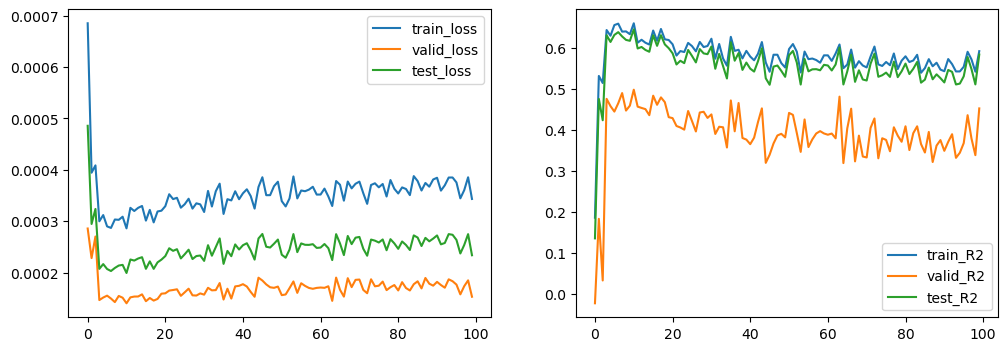

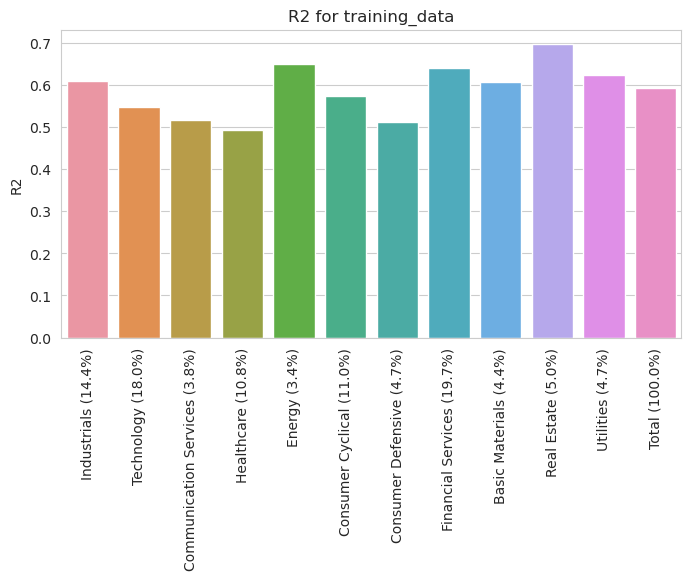

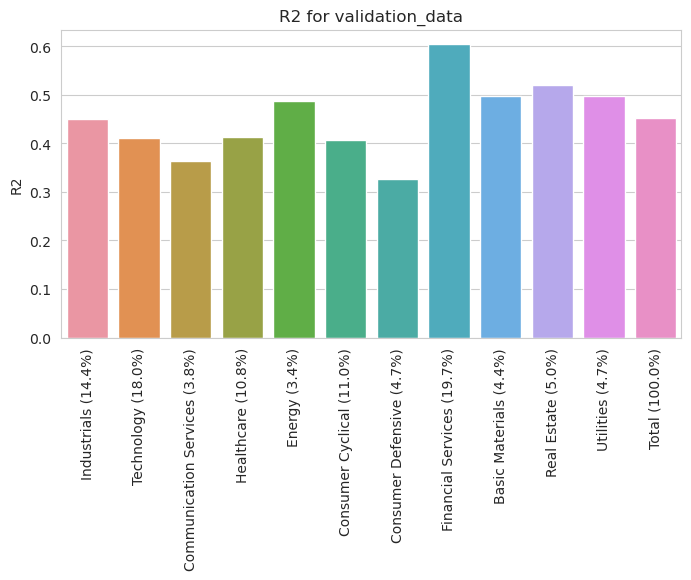

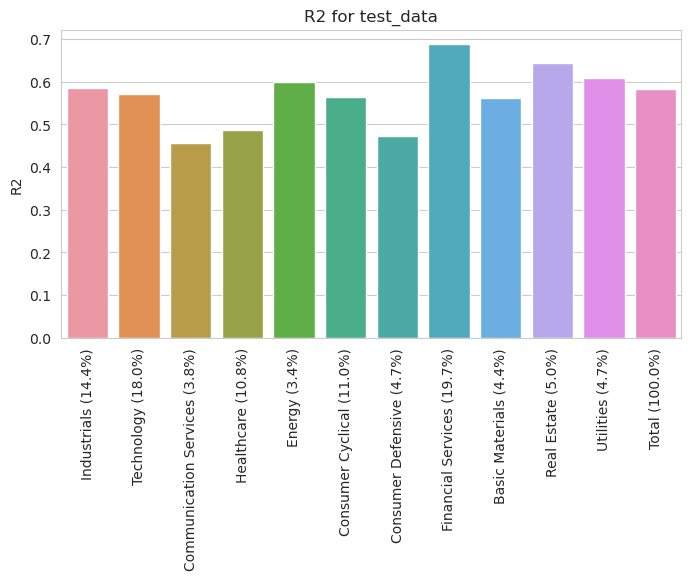

In [36]:
# ------- Run base model


dataset={
        'train' : training_data_b2_i,
        'validation' : validation_data_b2_i,
        'test' : test_data_b2_i 
    }

dataloader_b2={
        'train' : train_dataloader_b2_i,
        'validation' : validation_dataloader_b2_i,
        'test' : test_dataloader_b2_i 
    }

model_info="Model: base model AEfactors=20"


feature_vec_dim_b2=no_beta_factors+1
output_vec_dim=1
num_layers=5
num_hidden_nodes=50
P_dropout=0.2
lr=1e-3
epochs=100
fname='run_base_20'

run_b2(feature_vec_dim_b2,output_vec_dim,num_layers,num_hidden_nodes,P_dropout,lr,epochs,fname,model_info,dataloader_b2,dataset)

##  _Extended_ model where number of AE factors is 20

In [37]:
batch_size_adv=1000 # Batch size

# Create data loaders.

training_data_adv_i=market_data_adv(data_i,T_bkwd,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_adv_i=market_data_adv(data_i,T_bkwd,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_adv_i=market_data_adv(data_i,T_bkwd,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_adv_i = DataLoader(training_data_adv_i, batch_size=batch_size_adv,shuffle=True)
validation_dataloader_adv_i=DataLoader(validation_data_adv_i, batch_size=batch_size_adv,shuffle=True)
test_dataloader_adv_i = DataLoader(test_data_adv_i, batch_size=batch_size_adv,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_adv_i.__len__()}')
print(f'number of validation batches {validation_dataloader_adv_i.__len__()}')
print(f'number of test batches {test_dataloader_adv_i.__len__()}')


number of training batches 874
number of validation batches 880
number of test batches 880


NN_EM2(
  (activation): ReLU()
  (conv_block): Sequential(
    (0): Conv1d(20, 81, kernel_size=(2,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(81, 81, kernel_size=(2,), stride=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_aggr_block): Sequential(
    (0): Linear(in_features=81, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    

training R^2=0.681638240814209

validation R^2=0.45008134841918945

test R^2=0.6189240217208862

Epoch 29
-------------------------------
training R^2=0.6582199931144714

validation R^2=0.43562889099121094

test R^2=0.5965046882629395

Epoch 30
-------------------------------
training R^2=0.6820496916770935

validation R^2=0.4412599802017212

test R^2=0.6138044595718384

Epoch 31
-------------------------------
training R^2=0.6825019717216492

validation R^2=0.4441959857940674

test R^2=0.6143083572387695

Epoch 32
-------------------------------
training R^2=0.6851521730422974

validation R^2=0.4476863145828247

test R^2=0.6175358295440674

Epoch 33
-------------------------------
training R^2=0.6887432336807251

validation R^2=0.4482182264328003

test R^2=0.6186448335647583

Epoch 34
-------------------------------
training R^2=0.6848182082176208

validation R^2=0.44535011053085327

test R^2=0.615810751914978

Epoch 35
-------------------------------
training R^2=0.6824252009391785



test R^2=0.644782304763794

Epoch 88
-------------------------------
training R^2=0.7503050565719604

validation R^2=0.4869217276573181

test R^2=0.6426441669464111

Epoch 89
-------------------------------
training R^2=0.74699866771698

validation R^2=0.4866142272949219

test R^2=0.6413633823394775

Epoch 90
-------------------------------
training R^2=0.7500683069229126

validation R^2=0.48275840282440186

test R^2=0.6402983665466309

Epoch 91
-------------------------------
training R^2=0.7416825294494629

validation R^2=0.4735456705093384

test R^2=0.6334472894668579

Epoch 92
-------------------------------
training R^2=0.7442765831947327

validation R^2=0.4786984324455261

test R^2=0.6372970342636108

Epoch 93
-------------------------------
training R^2=0.7406777739524841

validation R^2=0.48112815618515015

test R^2=0.6360435485839844

Epoch 94
-------------------------------
training R^2=0.7431280016899109

validation R^2=0.46347516775131226

test R^2=0.636642336845398

Epoch 

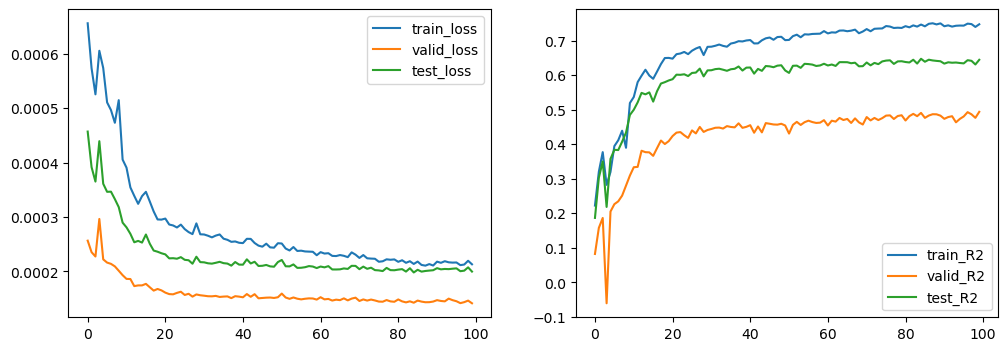

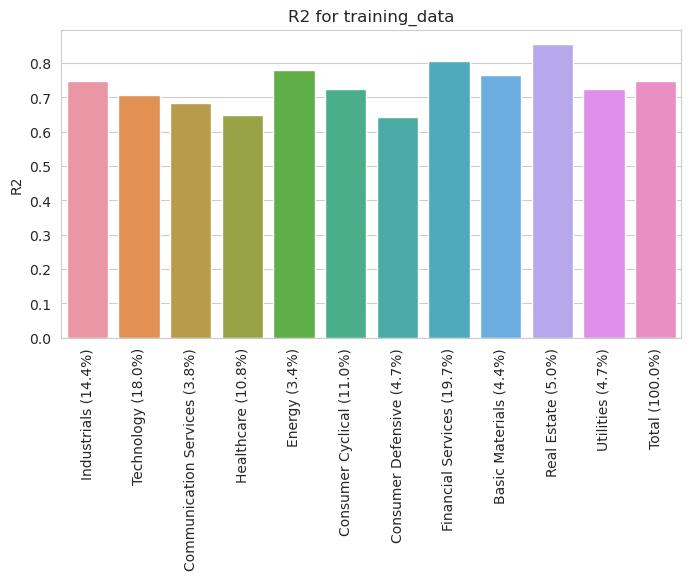

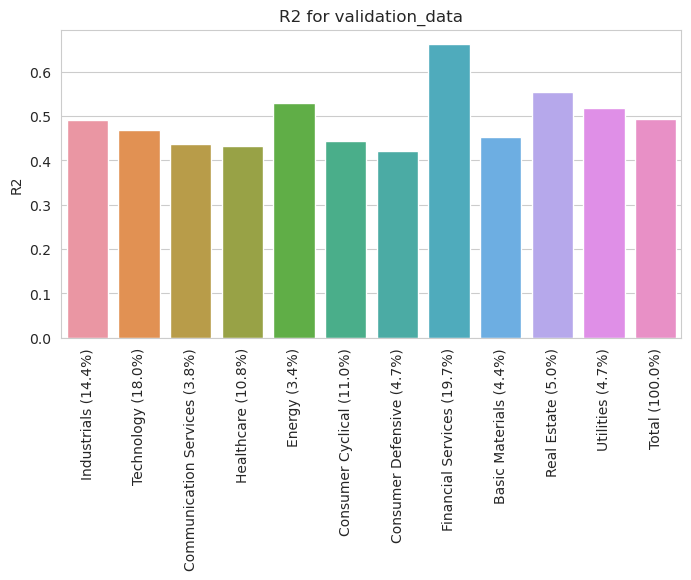

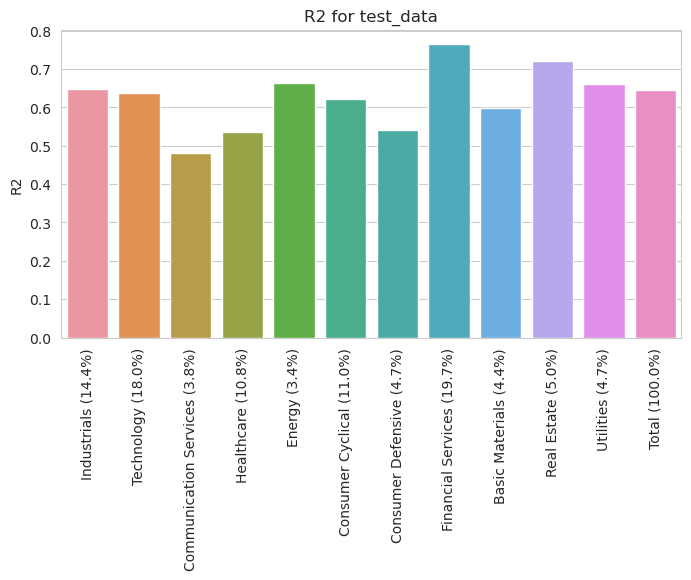

In [39]:
# ---------------- Run Extended model for AE factors=20

dataloader_adv={
        'train' : train_dataloader_adv_i,
        'validation' : validation_dataloader_adv_i,
        'test' : test_dataloader_adv_i 
    }

dataset={
    'train' : training_data_adv_i,
    'validation' : validation_data_adv_i,
    'test' : test_data_adv_i
}


T_bkwd=10


# Model parameters

feature_vec_cr_dim=no_beta_factors
feature_vec_LSTM_dim=2*no_beta_factors+2
feature_vec_FF_dim=2*no_beta_factors+1+4

no_conv_layers=2
channel_out=81
kernel_size=2
seq_lgth=T_bkwd-1

cr_aggr_no_layers=5
cr_aggr_no_nodes=100
cr_output_vec_dim=10

LSTM_hidden_layer_dim=10
LSTM_no_layers=5
LSTM_no_nodes=100
LSTM_output_vec_dim=10

num_layers_FF=5
num_hidden_nodes_FF=400
P_dropout=0.2

epochs_E2=100

fname='run_extended_20'
dataloader=dataloader_adv
model_info="Model: EM20\n\n"
lr=5e-4
weight_decay=1e-9

run_E2_E2(T_bkwd,\
          feature_vec_cr_dim,\
          feature_vec_LSTM_dim,\
          feature_vec_FF_dim,\
          no_conv_layers,\
          channel_out,\
          kernel_size,\
          cr_aggr_no_layers,\
          cr_aggr_no_nodes,\
          cr_output_vec_dim,\
          LSTM_hidden_layer_dim,\
          LSTM_no_layers,\
          LSTM_no_nodes,\
          LSTM_output_vec_dim,\
          num_layers_FF,\
          num_hidden_nodes_FF,\
          P_dropout,\
          epochs_E2,\
          fname,\
          dataloader,\
          dataset,\
          model_info,\
          lr,\
          weight_decay)